# Install and load libraries as necessary

In [1]:
# Package names
packages <- c("dplyr", "doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis")

# Install packages if necessary
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {
  install.packages(packages[!installed_packages])
}

# Load packages
invisible(lapply(packages, library, character.only = TRUE))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: viridisLite



# Define all the functions used

## Function to delete a file if it exists

In [2]:
# check if file at path exists, delete if it does
# will only call in functions that generate new files
cleanFile <-function(path){
  if(file.exists(path)){
    cat(sprintf("Deleting old file: %s\n",path))
    file.remove(path)
  }
}

## Function to create a new directory if it does not exist

In [3]:
# check if directory exists, create if not
newDir <- function(dirPath){
  if(dir.exists(dirPath)){
    cat(sprintf("Output directory, %s, already exists\n", dirPath))
  }
  else{
    cat(sprintf("Output directory not found, creating: %s\n",dirPath))
    dir.create(dirPath)
  }
}

## Function to save a list of plots

In [4]:
#input list of plots, output directory, custom directory path or tag
#output save each plot to output directory
#800 is a little over 5" on my screen at 1920x1080
savePlotList <-function(plotList, tag="", width=800, height=800, od=outputDir){
  plots <- names(plotList)
  for(i in 1:length(plots)){
    pngPath = paste(sep="", od, tag, plots[i], ".png")
    png(file=pngPath, width=width, height=height)
    print(plotList[[ plots[i] ]])
    dev.off()
  }
}

## Function to save a list of list of plots

In [5]:
savePlotListList<-function(pll, tag="", width=800, height=800, od=outputDir){
    for(i in 1:length(pll)){
        savePlotList(pll[[i]], od, tag=paste(tag,names(pll[i]),"_",sep=""), width=width, height=height)
    }
}

## Function for concatenating .CSV files larger than 500 bytes within one project folder and subfolders and removing debug lines

In [6]:
concat_run<-function(directory){
    #define custom call to read.csv and remove debug lines & where logger is not populated
    readCSV<-function(filePath){
        fileData<-read.csv(filePath,header=TRUE)
        fileData<-subset(fileData, type!="debug" & !is.na(logger))
    }
    
    #list all .CSV in folders and subfolders
    wb_files<-list.files(path=directory, recursive=TRUE, pattern="*.CSV$", full.names=TRUE)
    
    #subset files larger than 500 bytes
    wb_files<-subset(wb_files, file.info(wb_files)[,1]>300)
    
    #read each file and output a single dataframe
    data<-do.call(rbind, lapply(wb_files,readCSV))
    return(data)
}

## Function to process column data types

In [7]:
process_columns<-function(df){
    df$type<-as.factor(df$type)
    df$site<-as.factor(df$site)
    df$logger<-as.factor(df$logger)
    df$deployment<-as.factor(df$deployment)
    df$deployed_at<-as.integer(df$deployed_at)
    df$uuid<-as.factor(df$uuid)
    df$time.s<-as.numeric(df$time.s)
    df$time.h<-lubridate::as_datetime(df$time.h)
    
    cols<-names(df)
    if("measurementCycle" %in% cols & "burstCycle" %in% cols){
        df$measurementCycle<-as.numeric(df$measurementCycle)
        df$burstCycle<-as.factor(df$burstCycle)
    }
    
    ##hardcoded, but could be all columns between time.h and user_note? or measurementCycle when included
    df$battery.V<-as.numeric(df$battery.V)
    df$dht_C<-as.numeric(df$dht_C)
    df$dht_RH<-as.numeric(df$dht_RH)
    
    if("atlas_CO2_ppm" %in% cols){
        df$atlas_CO2_ppm<-as.numeric(df$atlas_CO2_ppm)
    }
    
    df$ch4rf_raw<-as.numeric(df$ch4rf_raw)
    df$ch4rf_cal<-as.numeric(df$ch4rf_cal)
    df$ch4_raw<-as.numeric(df$ch4_raw)
    df$ch4_cal<-as.numeric(df$ch4_cal)
    
    return(df)
}

## Function that parses through the data and assigns a burst number and then counts each measurement in a burst. (Data will eventually have measurementCycle and burstCycle natively)

In [8]:
parse_data<-function(df,burst_interval_threshold,measure_cycle_size){
    #check if measurementCycle and burstCycle already present in data:
    cols<-names(df)
    if("measurementCycle" %in% cols & "burstCycle" %in% cols){
        return(df)
    }
    
    df$interval<-df$time.s-Lag(df$time.s,shift=1)

    measurementCycle<-1
    burstCycle<-1
    reading<-1
    df$measurementCycle<-1
    df$burstCycle<-1
    df$reading<-1
    comp_rows<-nrow(df)
    
    for(i in 1:comp_rows){
        if(!is.na(df$interval[i])){
            if(df$interval[i]>burst_interval_threshold){
                burstCycle<-burstCycle+1
                reading<-1
                df$burstCycle[i:comp_rows]<-burstCycle
                df$reading[i]<-reading
            }else{
                df$reading[i]<-reading
                reading<-reading+1
            }
            if(burstCycle == measure_cycle_size){
                measurementCycle<-measurementCycle+1
                df$measurementCycle[i:comp_rows]<-measurementCycle
                burstCycle<-0
            }            
        }
    }
    df$burstCycle<-as.factor(df$burstCycle)
#     df$measurementCycle<-as.factor(df$measurementCycle)
    return(df)
}

## Function to process each logger individually and output single dataframe

In [9]:
parseIndividualLoggers<-function(df, ll=loggerList, lc=loggerCount){
    loggerDataList<-vector("list", lc) #empty list to hold temporary data frames
    
    #subset each logger's data and parse
    for(i in 1:lc){
        loggerDataList[[i]]<-parse_data(subset(df, logger==ll[i]), 30, 30)
    }
    return(bind_rows(loggerDataList))
}

## Function to create basic plots of burst vs raw methane reading colored by measurement cycle

In [10]:
cycleVsCH4_plots<-function(processed_data, dataType, lc=loggerCount, ll=loggerList){
    plots<-vector("list", lc)
    names(plots)<-ll
    for(i in 1:lc){
        data<-subset(processed_data, logger==ll[i] & type==dataType)

        plots[[i]]<-ggplot(data, aes(burstCycle, ch4_raw))+
            geom_point(aes(color=measurementCycle))+scale_color_viridis()+
            ggtitle(paste("Logger: ", ll[i], "\nData type: ", dataType))
        
#         # TODO, doesn't matter if there's no data?
#         if(length(data[,1])>0){
#             plots[[i]]<-ggplot(data,aes(burstCycle,ch4_raw))+
#                 geom_point(aes(color=measurementCycle))+scale_color_viridis()+
#                 ggtitle(paste("Logger: ",ll[i],"\nData type: ", dataType))
#         }else{
#             plots[[i]]<-NULL
#         }
    }
    return(plots)
}

## Function to calculate rolling CV for warm-up detection
Starting with using the summary data for calculations

In [11]:
calculateCV<-function(processed_data, dataType, lc=loggerCount, ll=loggerList){
    temp_cv<-data.frame()
    calculated_cv_list<-vector("list", lc)
    for(i in 1:lc){
        df<-subset(processed_data, logger==ll[i] & type==dataType)

        measurementCycles<-unique(df$measurementCycle)
        for(i in 1:length(measurementCycles)){
            temp<-subset(df,measurementCycle==measurementCycles[i])
            temp$roll_mean<-rollapply(data=temp$ch4_raw,width=4,align=c("right"),FUN=mean,fill=NA)
            temp$roll_sd<-rollapply(data=temp$ch4_raw,width=4,align=c("right"),FUN=sd,fill=NA)
            temp$roll_cv<-temp$roll_sd/temp$roll_mean #optionally multiply by 100 for %
            temp_cv<-bind_rows(temp_cv,temp)
        }
        calculated_cv_list[[i]]<-temp_cv
    }
    return(bind_rows(calculated_cv_list))
}

## Function to save a dataframe as an rds

In [12]:
saveDFrds<-function(inputDF, od=outputDir){
    dfName<-substitute(inputDF)
    outputPath<-paste(od,dfName,".rds",sep="")
    print(outputPath)
    saveRDS(inputDF, outputPath)
}

## Function to save a dataframe as a csv

In [13]:
saveDFcsv<-function(inputDF, od=outputDir){
    dfName<-substitute(inputDF)
    outputPath<-paste(od,dfName,".csv",sep="")
    print(outputPath)
    write.csv(inputDF, outputPath)
}

## Function to plot rolling cv vs burst cycle and colored by measurement cycle

In [14]:
rollCV_plots<-function(parseDataCV, ll=loggerList, lc=loggerCount){
    plots<-vector("list", lc)
    names(plots)<-ll
    for(i in 1:lc){
        data<-subset(parseDataCV, logger==ll[i])
        plots[[i]]<-ggplot(data, aes(burstCycle, roll_cv))+
        geom_point(aes(color=as.integer(measurementCycle)))+
        scale_y_log10()+scale_color_viridis()+
        ggtitle(paste("Rolling CV for Logger: ",ll[i]))
    }
    return(plots)
}

# Initial Setup

## Define location of data

In [15]:
#directory<-"/Users/jhosen/Library/CloudStorage/GoogleDrive-jakehosen@gmail.com/My Drive/WaterBear/CH4DHT22/20221110_pull/bin"
# directory<-"~/Desktop/data/mesoBinTests/20221110_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221118_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221127_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221205_pull"
# directory<-"~/Desktop/data/mesoBinTests/20221214_pull"
directory<-"~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV"
# directory<-"~/Desktop/data/mesoBinTests//20230106_pull"
# directory<-"~/Desktop/data/mesoBinTests/20230111_floatingbucket"
# directory<-"~/Desktop/data/20230111_bench"

# directory<-"~/Desktop/data/mesoBinTests/20230118_floatingbucket/RRIV" #didn't have enough data here
# directory<-"~/Desktop/data/mesoBinTests/20230119_floatingbucket/RRIV"

## Create global variable directory for outputs based on data directory

In [16]:
outputDir<-paste(directory,"_output/",sep="")
newDir(outputDir)

Output directory, ~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/, already exists


## Import experiment data into a dataframe and process its columns

In [17]:
comp_data<-concat_run(directory)
comp_data<-process_columns(comp_data)
# TODO: count NAs in each column for error checking?

## Process data and global create variables for use later

In [18]:
loggerList<-unique(comp_data$logger) #save each individual logger
loggerList

loggerCount<-length(loggerList) #how many loggers
loggerCount

#for measurementCycle and burstCycle, not necessary with updated code
processed_data<-parseIndividualLoggers(comp_data)

[1] 21010 21011
Levels: 21010 21011

[1] 2

## Specific processing depending on data

In [19]:
# This data had a timestamp issue on measurement cycle 51 to 52, first change in day from 12-01 to 12-02, for all data loggers
# add 1 day's worth of seconds to all data after that point to correct (1*24*60*60)
if(basename(directory)=="20221205_pull"){
    processed_data$time.s<-ifelse(processed_data$measurementCycle>51, processed_data$time.s+86400, processed_data$time.s)
    processed_data$time.h<-lubridate::as_datetime(processed_data$time.s)
}

## Save processed dataframe as .rds to output folder

In [20]:
saveDFrds(processed_data)
saveDFcsv(processed_data)

[1] "~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/processed_data.rds"
[1] "~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/processed_data.csv"


### Create plots of raw data and summary data and save them

In [21]:
raw_cycleVsCH4_plots<-cycleVsCH4_plots(processed_data, "raw")
summary_cycleVsCH4_plots<-cycleVsCH4_plots(processed_data, "summary")

savePlotList(raw_cycleVsCH4_plots, "raw_cycleVsCH4_")
savePlotList(summary_cycleVsCH4_plots, "summary_cycleVsCH4_")

$`21010`

$`21011`


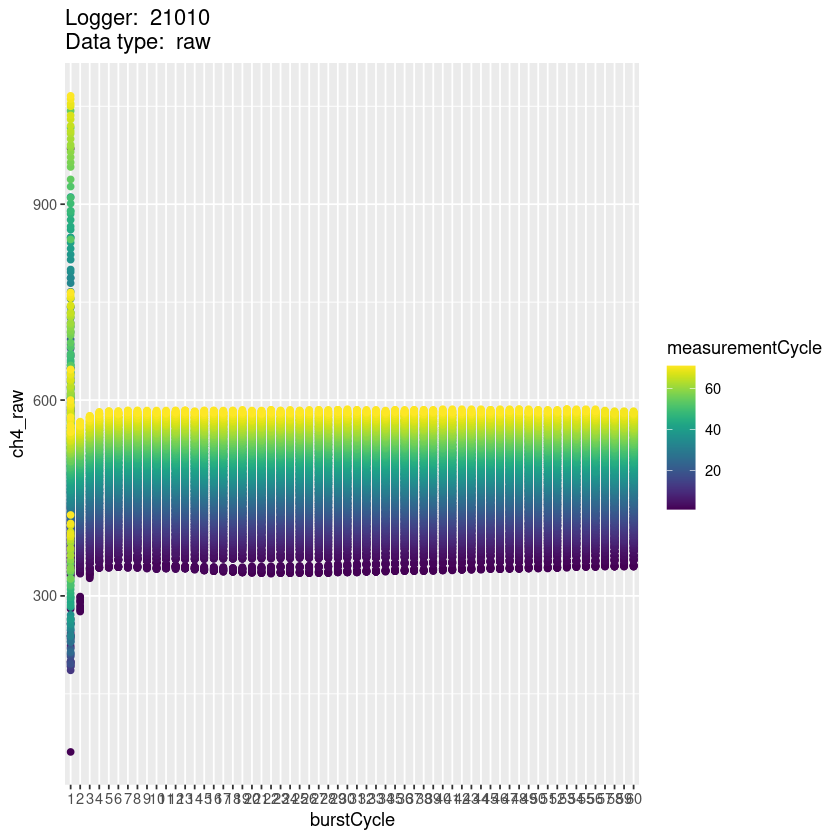

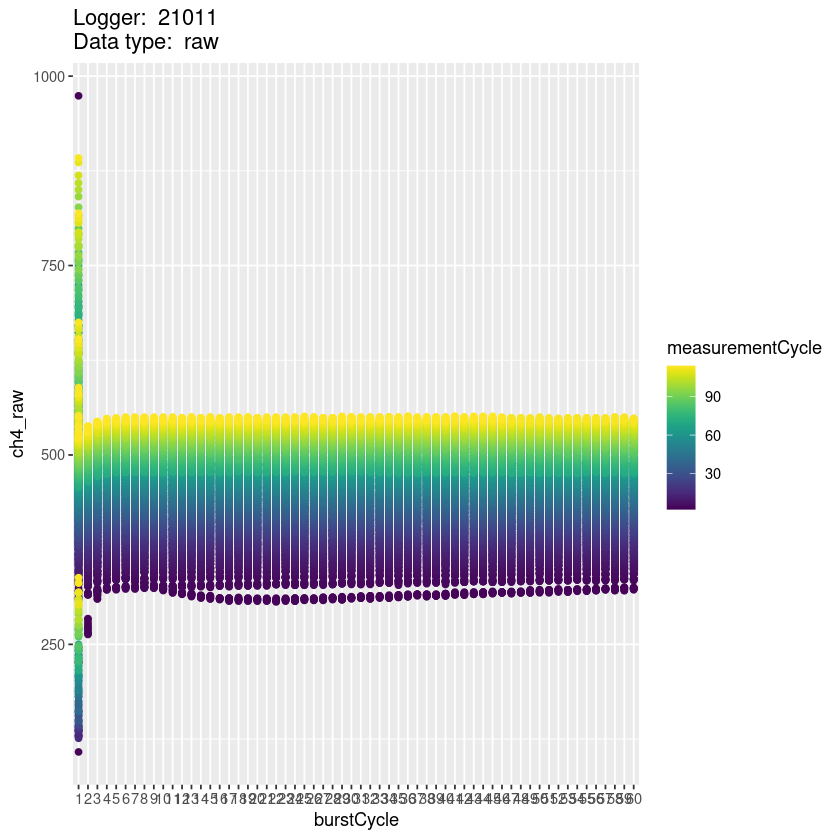

In [22]:
raw_cycleVsCH4_plots

$`21010`

$`21011`


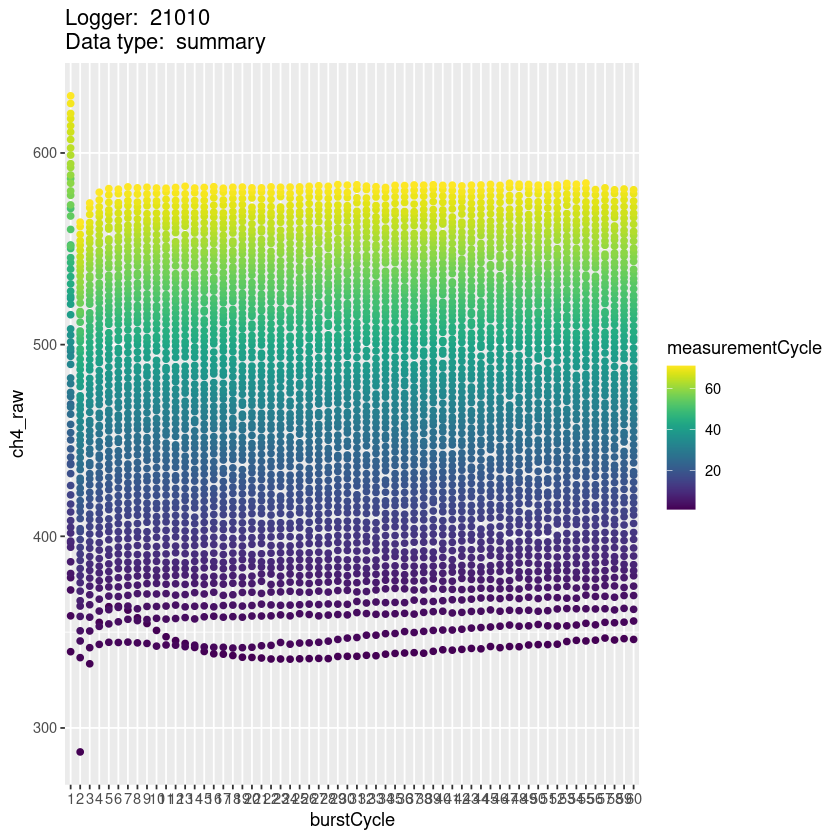

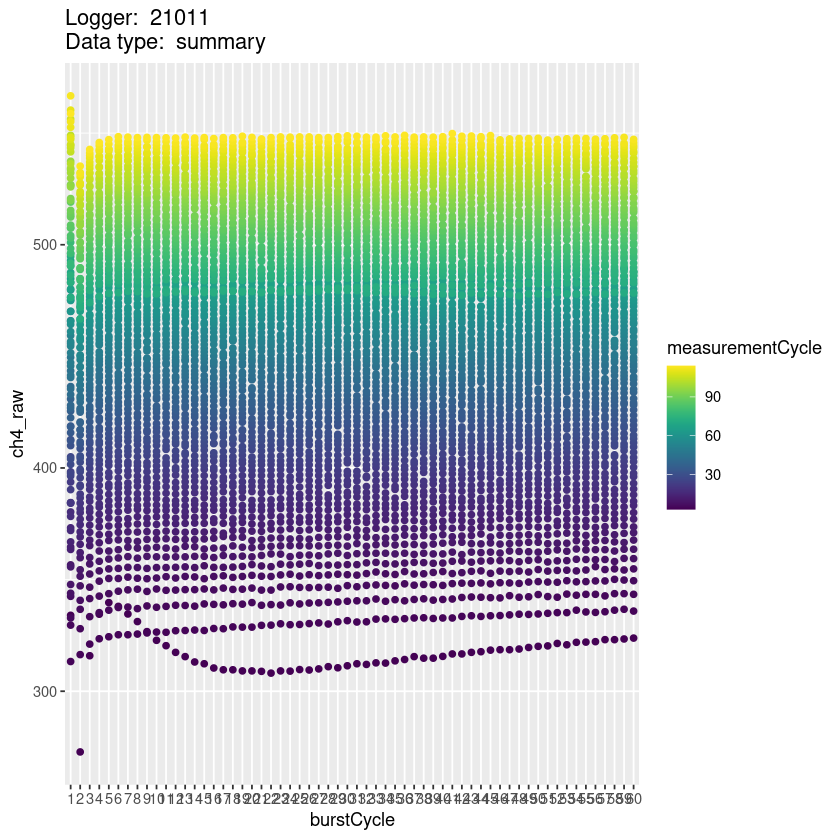

In [23]:
summary_cycleVsCH4_plots

#### Note: you can modify plots after the fact:

In [24]:
#plots[["21003"]]+ggtitle("Overwrite")

#### Save the final processed dataframe to RDS file

In [25]:
parseSummaryDataCV<-calculateCV(processed_data, "summary")

saveDFrds(parseSummaryDataCV)
saveDFcsv(parseSummaryDataCV)

[1] "~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/parseSummaryDataCV.rds"
[1] "~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/parseSummaryDataCV.csv"


### Create rolling cv plots and save them

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 426 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 336 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 426 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 336 rows containing missing values (geom_point).”


$`21010`

$`21011`


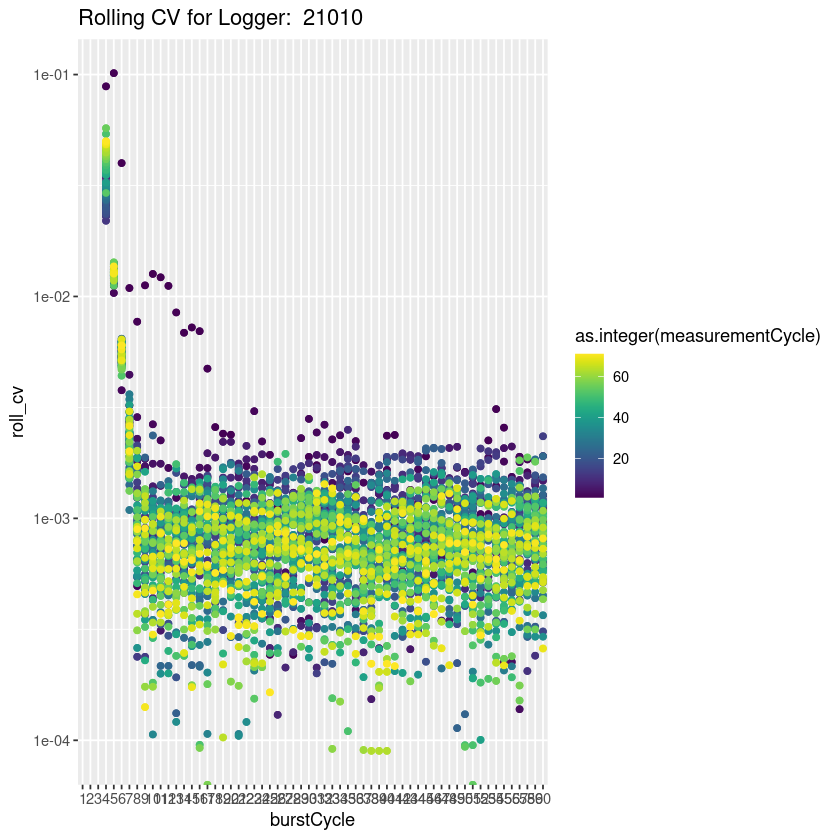

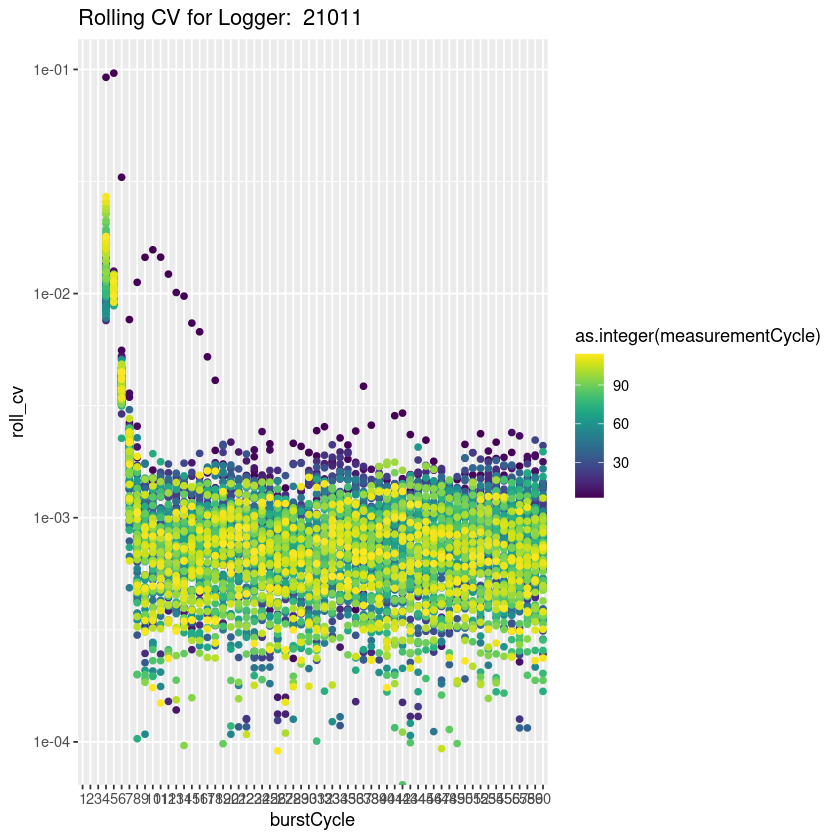

In [26]:
summaryDataCV_plots<-rollCV_plots(parseSummaryDataCV)

savePlotList(summaryDataCV_plots, "summaryDataCV_")

summaryDataCV_plots

## Function to calculate the mean of rolling cv above provided burst for each measurement cycle to determine target cv for methane driver

In [27]:
mean_cv_burst<-function(parseDataCV, burstCycleStart, ll=loggerList, lc=loggerCount){
    mean_na<-function(x){mean(x,na.rm=TRUE)}
    
    temp_mean<-vector("list", lc)
    for(i in 1:lc){
        df<-subset(parseDataCV, logger==ll[i] & as.integer(burstCycle)>=burstCycleStart)
        
        if(max(df$measurementCycle) > 2){
            temp_mean[[i]]<-summaryBy(roll_cv~measurementCycle,df,FUN=c(mean_na))
            temp_mean[[i]]$logger<-unique(df$logger)
            temp_mean[[i]]$deployed_at<-lubridate::as_datetime(unique(df$deployed_at))
        }
    }
    return(bind_rows(temp_mean))
}

## calculate the mean cv of each burst and save it

In [28]:
meanCVburst<-mean_cv_burst(parseSummaryDataCV, 20)

saveDFrds(meanCVburst)
saveDFcsv(meanCVburst)

[1] "~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/meanCVburst.rds"
[1] "~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/meanCVburst.csv"


### Print results

In [29]:
for(i in 1:length(loggerList)){
    print(loggerList[i])
    print(subset(meanCVburst, logger==loggerList[i]))
}

[1] 21010
Levels: 21010 21011
   measurementCycle roll_cv.mean_na logger         deployed_at
1                 1    0.0014142503  21010 2022-12-16 20:56:32
2                 2    0.0015753214  21010 2022-12-16 20:56:32
3                 3    0.0010242005  21010 2022-12-16 20:56:32
4                 4    0.0010699255  21010 2022-12-16 20:56:32
5                 5    0.0010260635  21010 2022-12-16 20:56:32
6                 6    0.0012447996  21010 2022-12-16 20:56:32
7                 7    0.0009939673  21010 2022-12-16 20:56:32
8                 8    0.0008715170  21010 2022-12-16 20:56:32
9                 9    0.0010311661  21010 2022-12-16 20:56:32
10               10    0.0008092510  21010 2022-12-16 20:56:32
11               11    0.0010062256  21010 2022-12-16 20:56:32
12               12    0.0009420130  21010 2022-12-16 20:56:32
13               13    0.0011430845  21010 2022-12-16 20:56:32
14               14    0.0009104841  21010 2022-12-16 20:56:32
15               15    0.

### Use this ^ data to decide a CV limit indicating when sensor has been sufficiently warmed
### Function to go through each logger and each measurement cycle and save the first instance where CV limit has been reached to an output dataframe

In [30]:
# first instance of CV lower than 0.01 for each measurementCycle indicates a good reading
# readings before that are not warmed up, readings after that are good but consume too much power
# Ideally we want 1 value (1 summary line and/or 10 raw lines from burst) per measurement cycle

# for each logger, for each measurement cycle, save 1 line to new dataframe
manualCVlimit<-function(parseSummaryDataCV, manualCV, ll=loggerList, lc=loggerCount){
    # TODO: first row is populated with NAs
    outputDF<-data.frame(matrix(ncol=length(parseSummaryDataCV), nrow=0))
    colnames(outputDF)<-names(parseSummaryDataCV)

    for(i in 1:lc){
        oneLogger<-subset(parseSummaryDataCV, logger==ll[i])

        measurementCycles<-length(unique(oneLogger$measurementCycle))

        for(j in 1:measurementCycles){
            oneCycle<-subset(oneLogger, measurementCycle==j)
            
            #save the first instance where the rolling cv has reached the desired limit
            # TODO: save line with the lowest CV reached if has not reached the desired limit
            # errors not an issue currently: reporting warnings where CV not calculated or mostly NA values
            rowFound<-min(which(oneCycle$roll_cv<manualCV), na.rm=TRUE)
            if(!is.integer(rowFound)){
                print(sprintf("cv limit not reached for logger:%s measurementCycle:%d", ll[i], j))
                print(sprintf("lowest cv is: %f", min(oneCycle$roll_cv, na.rm=TRUE)))
            }else{
                outputDF<-rbind(outputDF,oneCycle[rowFound,])
            }
        }
    }
    outputDF<-process_columns(outputDF)
    # either sort the categorical factor burst cycles or change them to numeric here:
    outputDF$burstCycle<-as.numeric(outputDF$burstCycle)
    return(outputDF)
}

### Subset good data and save it to rds and csv

In [31]:
summary_manualCVdata<-manualCVlimit(parseSummaryDataCV, 0.01)
# outputDF$measurementCycle<-as.numeric(outputDF$measurementCycle)

saveDFrds(summary_manualCVdata)
saveDFcsv(summary_manualCVdata)

#TODO: mean burstCycle(how many minutes it took to warm up) & standard error, and actual cv value

Warning message in min(which(oneCycle$roll_cv < manualCV), na.rm = TRUE):
“no non-missing arguments to min; returning Inf”


[1] "cv limit not reached for logger:21011 measurementCycle:1"


Warning message in min(oneCycle$roll_cv, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”


[1] "lowest cv is: Inf"


Warning message in min(which(oneCycle$roll_cv < manualCV), na.rm = TRUE):
“no non-missing arguments to min; returning Inf”


[1] "cv limit not reached for logger:21011 measurementCycle:2"


Warning message in min(oneCycle$roll_cv, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”


[1] "lowest cv is: Inf"
[1] "~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/summary_manualCVdata.rds"
[1] "~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV_output/summary_manualCVdata.csv"


### Create plots and save them

#### Hardcoded dictionary of column variables to plot and axis labels

In [32]:
# names(summary_manualCVdata)
# note can't use positions to create this list because different versions of code have them in different order
# though at some point it will be consistent and everything between "burstCycle" and "user_note" would work

#HARDCODED:list of variables to plot and custom axis labels, issue if any column not present

variableDict <- c(
    "battery.V"="Battery Digital\nReading (12bit)",
    "dht_C"="\nTemperature (°C)",
    "dht_RH"="\nRelative Humidity (%)",
#     "atlas_CO2_ppm"="\nCO2 (ppm)",
    "ch4rf_raw"="Raw Methane Reference\nDigital Reading (12bit)",
    "ch4rf_cal"="Calibrated Methane Reference\nDigital Reading (12bit)",
    "ch4_raw"="Raw Methane Digital\nReading (12bit)",
    "ch4_cal"="Calibrated Methane Digital\nReading (12bit)"
#     "roll_cv"="Rolling Coefficient\nof Variation"
)
# variableDict
# class(variableDict)
# names(variableDict)
# print(as.character(variableDict[1]))

variableCount<-length(variableDict)
# variableCount

variableKeys<-names(variableDict)
# variableKeys

# is this preferable to an index number?
# for(thing in names(variableDict)){print(thing)}

In [33]:
# scopeTest<-function(local=variableDict){
#     print(local)
#     print(class(local))
# }

# you can create functions with defaults to global variables, but not if the local variable is given the same name
# parameters with defaults should be at the end of the list otherwise it gets in the way of positional arguments
# argument names should be clear, as should global variable names, but they can't overlap #TODO

### function that goes through and does each series of basic plots of variable vs time.h, or just x vs y colored by logger/site

In [34]:
plot_Data_v_Time <-function(df, color="logger", vd=variableDict, vk=variableKeys, vc=variableCount){
  # initialize list to hold plots
  DvT = vector('list', vc)
  names(DvT) = names(vd)
  
  # plot each column vs time with all deployments into list
  for ( i in 1:vc ){
    DvT[[i]] = ggplot(data=df)+
      geom_point(aes_string(x="time.h",y=vk[i],color=color),size=1)+theme_classic(base_size=12)+
      labs(x="Date", y=vd[i], color=NULL)
    # +
    #   scale_color_manual(values=custom_colors2,na.translate=F)+
    #   scale_x_datetime(date_labels="%m/%d %H",breaks=scales::pretty_breaks(n=4),expand=c(0,60*5))
  }
  return(DvT)
}

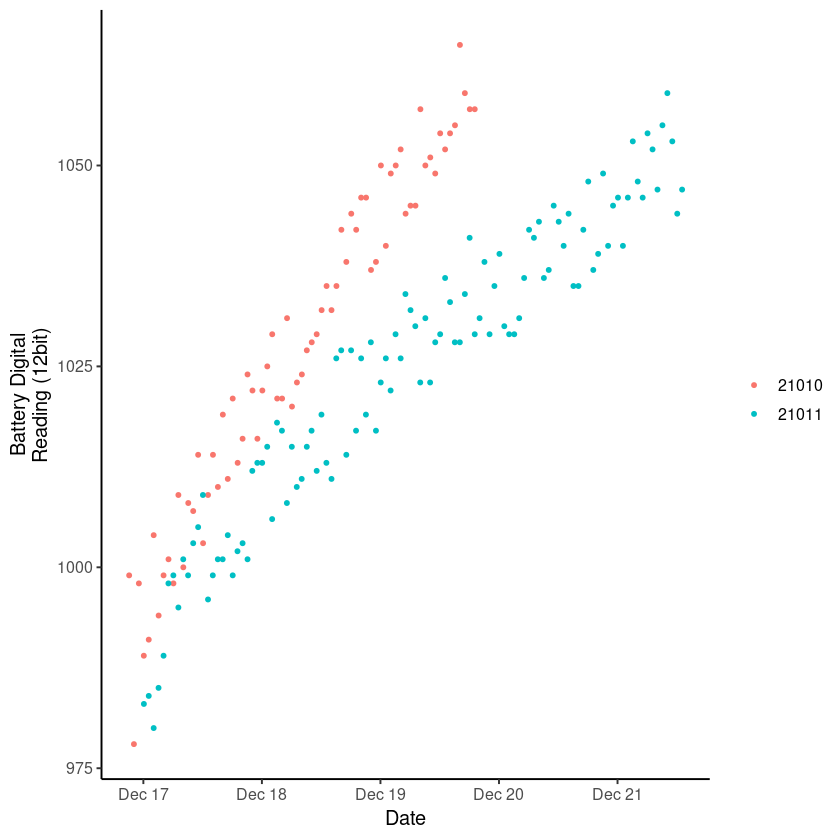

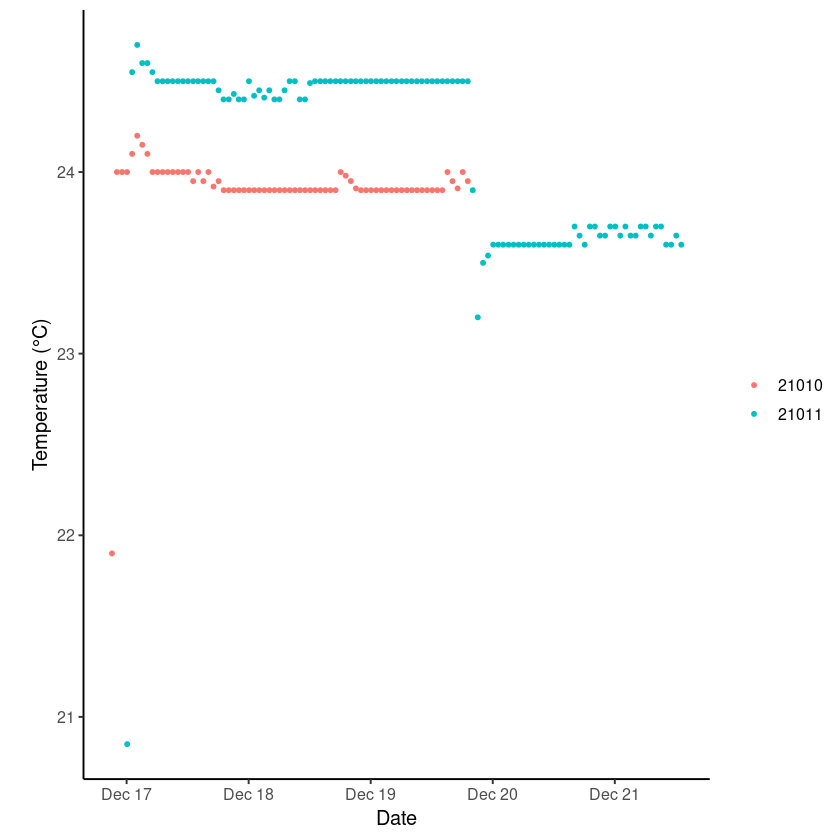

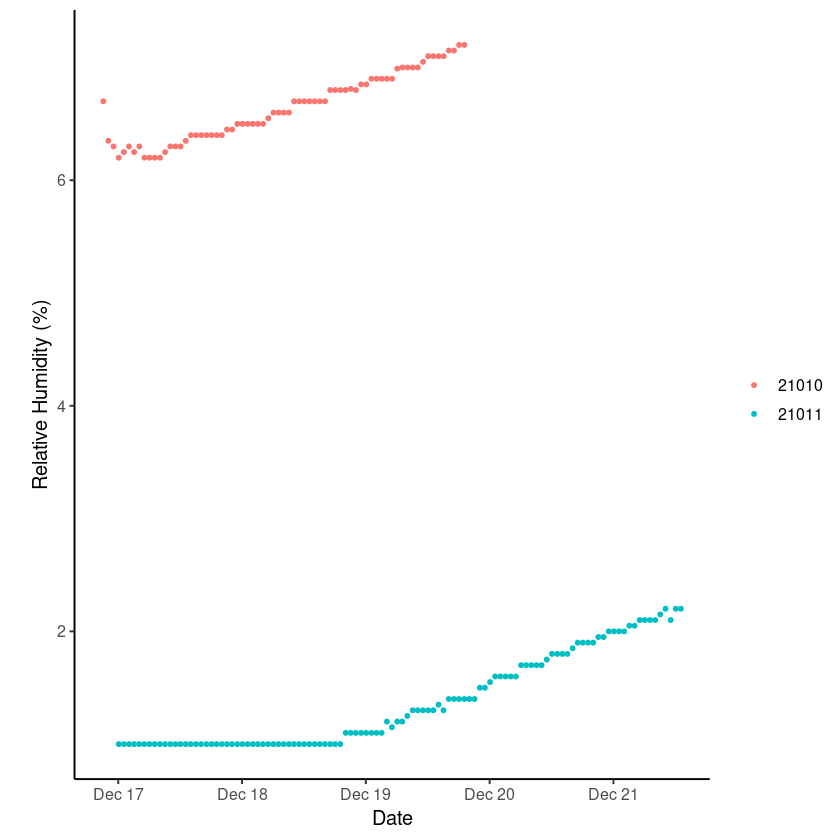

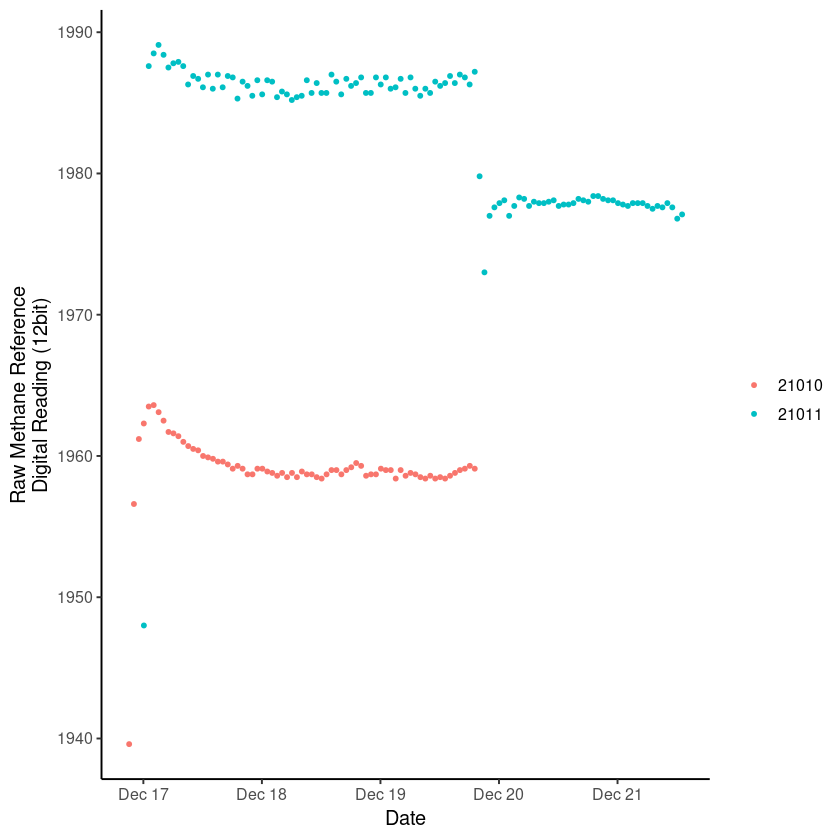

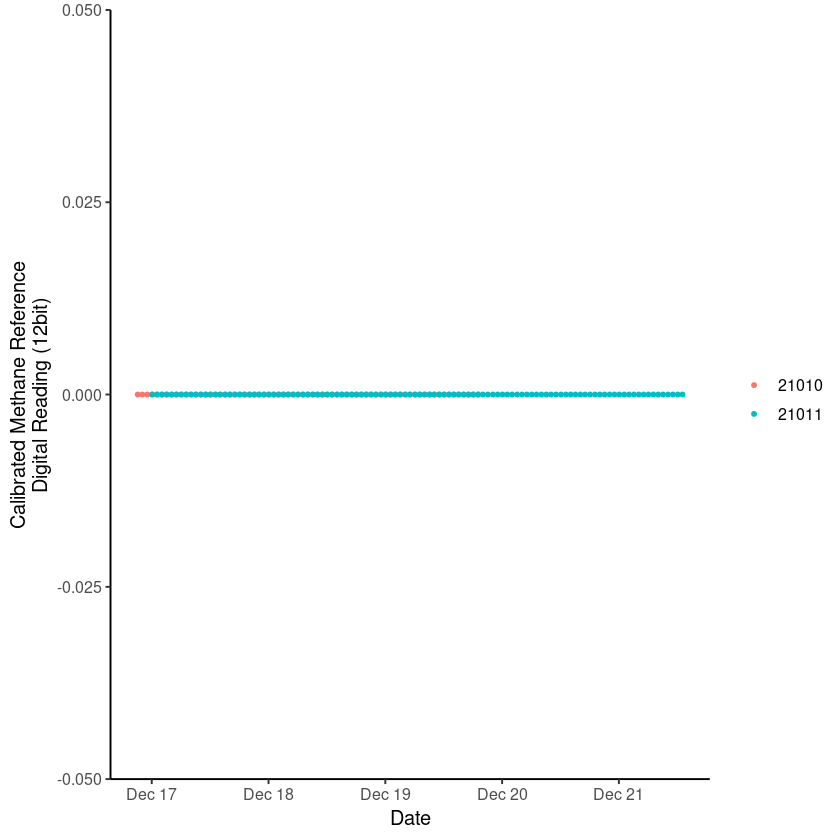

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


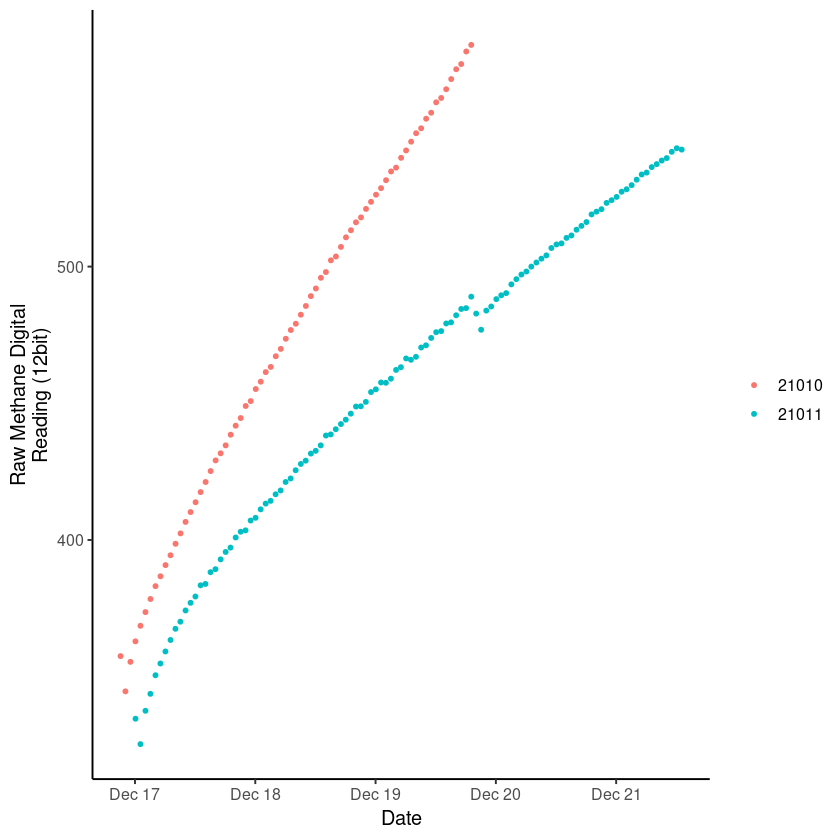

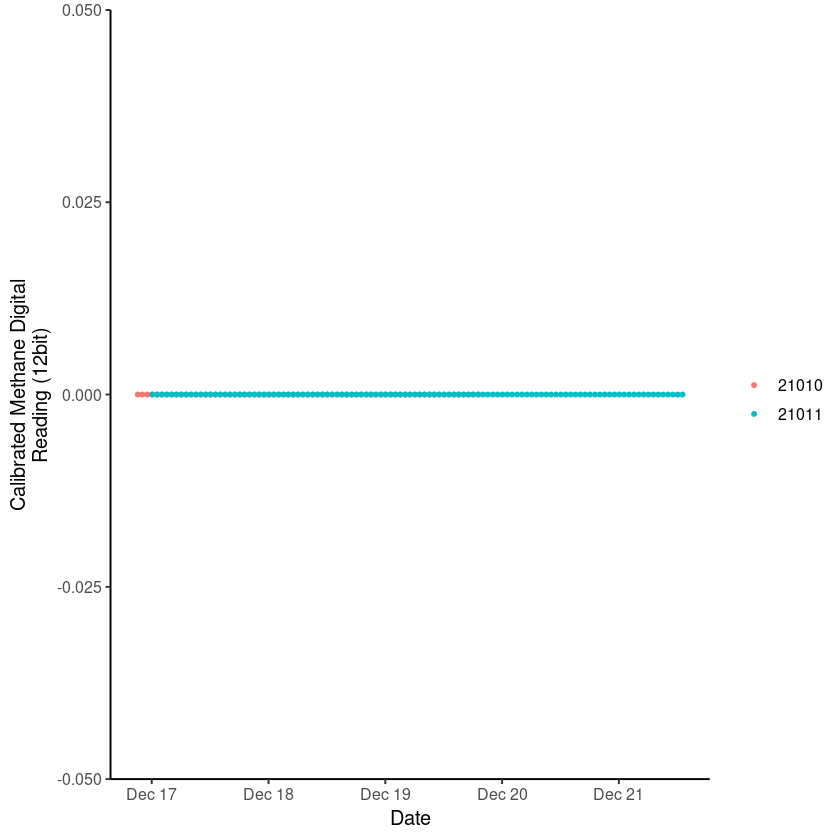

In [35]:
loggerPlots<-plot_Data_v_Time(summary_manualCVdata, "logger")
loggerPlots

savePlotList(loggerPlots, "lp_manualCV_")

### function that goes through and does each series of basic plots of variable vs time.h for each individual logger

In [36]:
plot_individual_logger_data_v_time <-function(df, vd=variableDict, vk=variableKeys, vc=variableCount,
                                              ll=loggerList, lc=loggerCount){
    ## list of lists, where list values are the names of columns and loggers for the deployment
    output <- vector("list", vc)
    names(output) <- vk
    
    # initialize empty double list to hold plots
    for(i in 1:vc){
        output[[ vk[i] ]] <- vector("list", lc)
        names( output[[ vk[i] ]] ) <- loggerList
    }
    
    # create plots at respective locations
    for(i in 1:vc){
        for(j in 1:lc){
          output[[ vk[i] ]][[ ll[j] ]] = ggplot(data=subset(df, logger==ll[j]))+
            geom_point(aes_string(x="time.h",y=vk[i]),size=1)+theme_classic(base_size=12)+
            ylab(vd[i])+xlab("Date")+ggtitle(paste("Logger: ",ll[j],sep=""))
          # +
          #   scale_color_manual(values=custom_colors2,na.translate=F)+
          #   scale_x_datetime(date_labels="%m/%d %H",breaks=scales::pretty_breaks(n=4),expand=c(0,60*120))
        }
    }
    return(output)
}

In [37]:
# individualPlots<-plot_individual_logger_data_v_time(summary_manualCVdata)

# individualPlots

# savePlotListList(individualPlots, "ip_manualCV_")

In [38]:
raw_processed_data<-subset(processed_data, type=="raw")
summary_processed_data<-subset(processed_data, type=="summary")

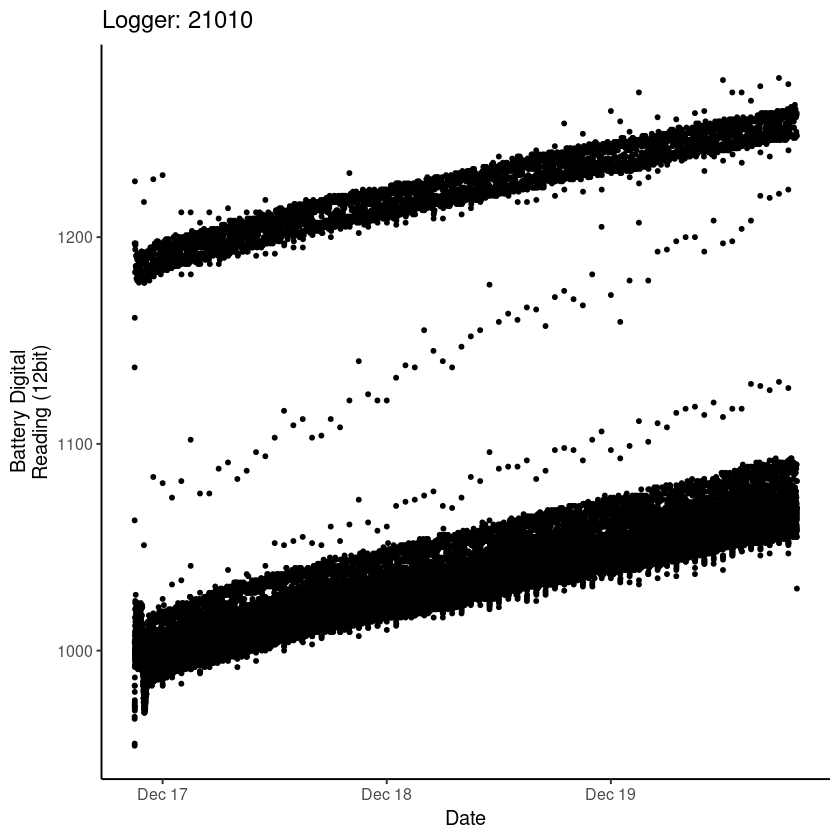

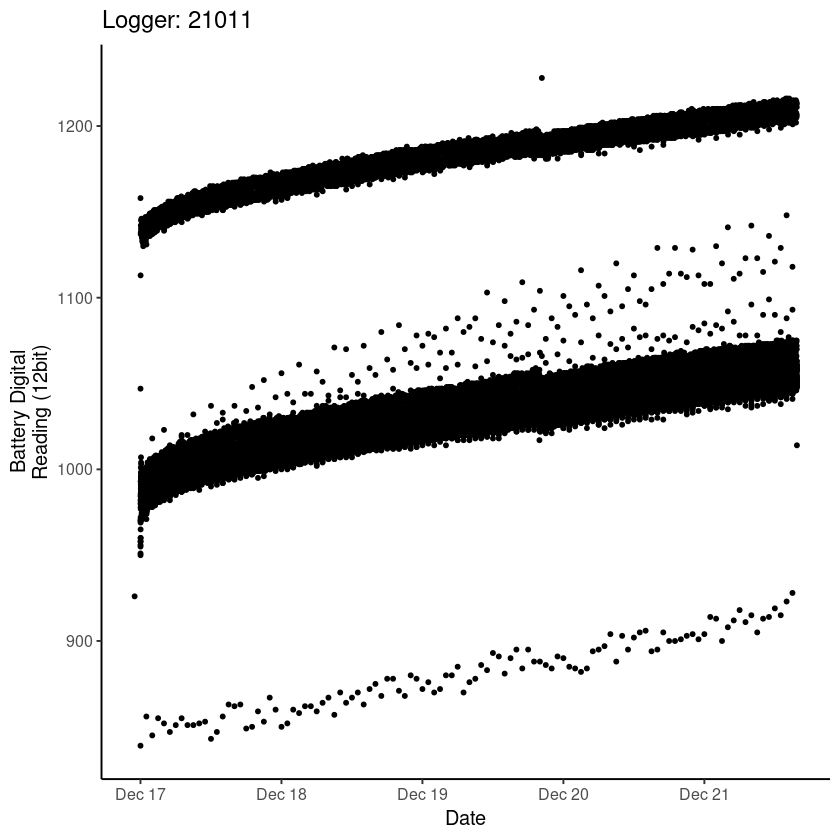

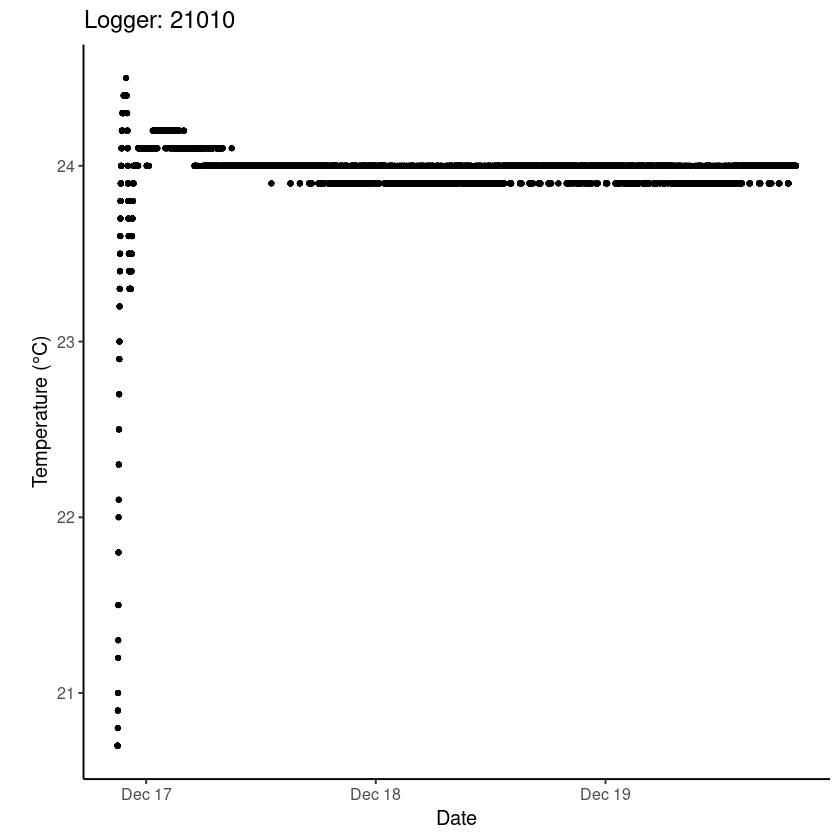

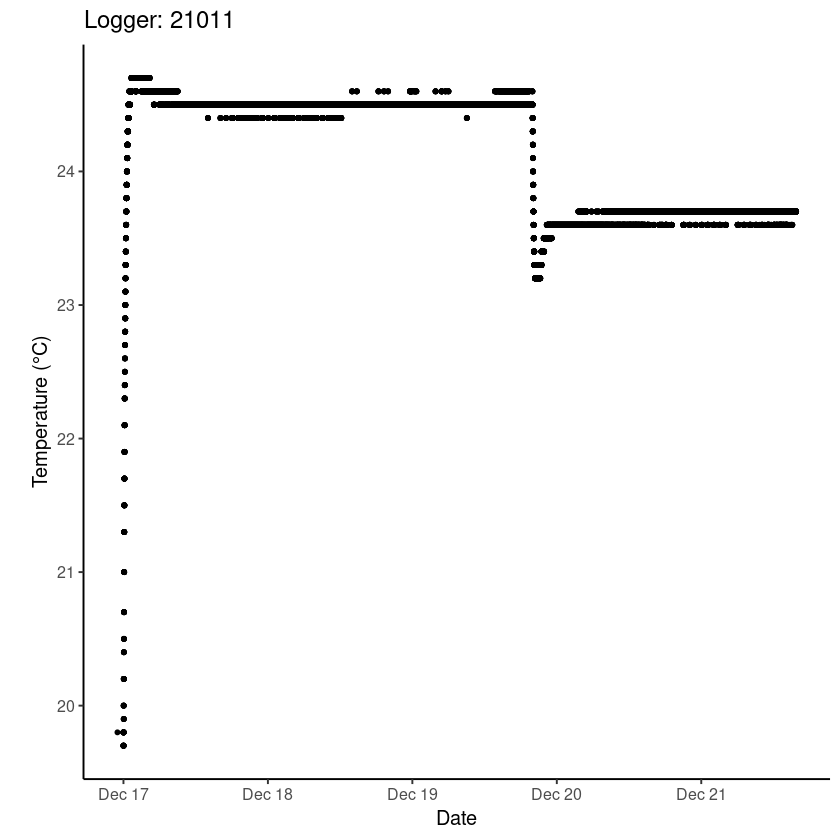

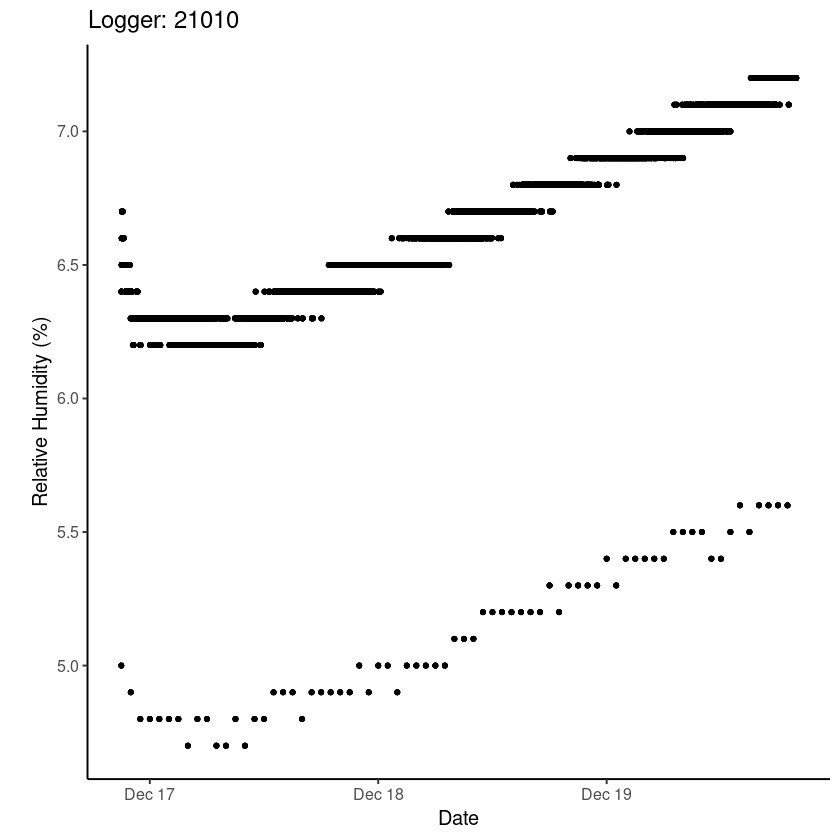

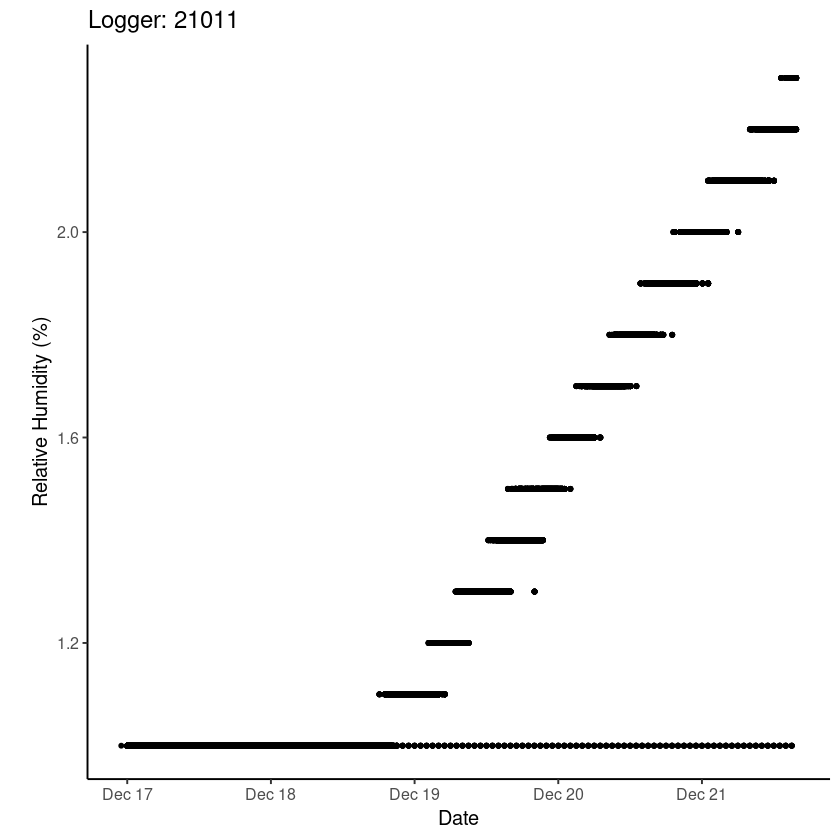

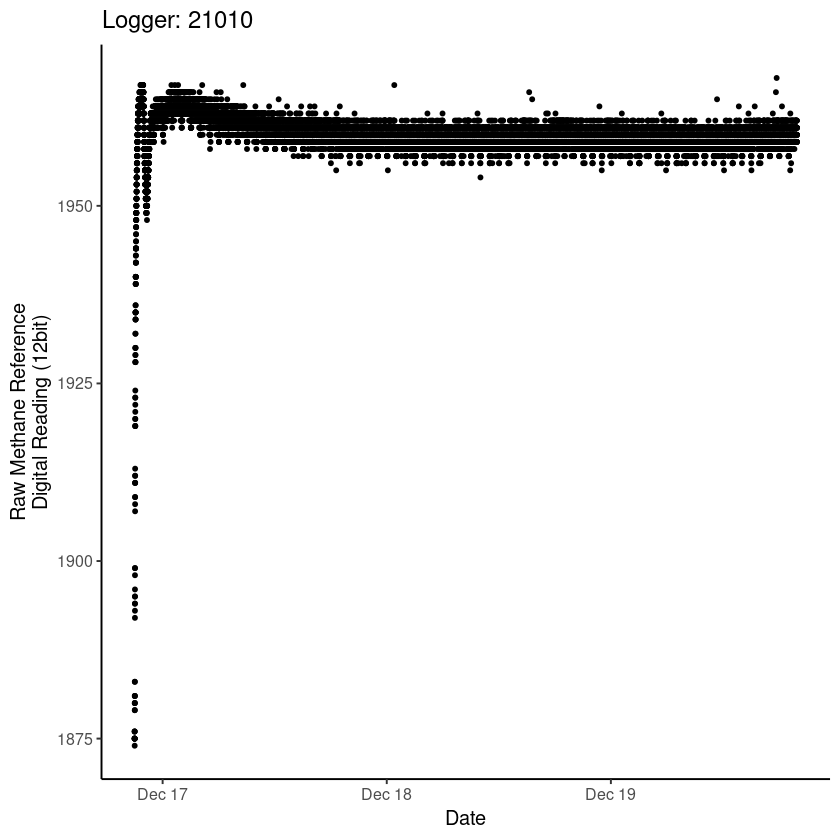

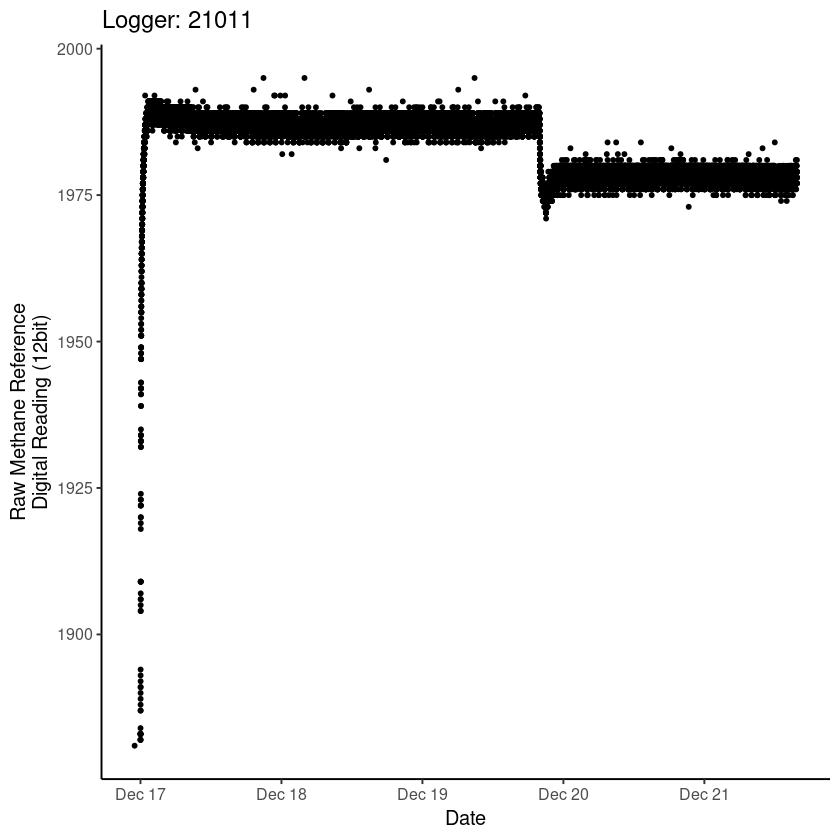

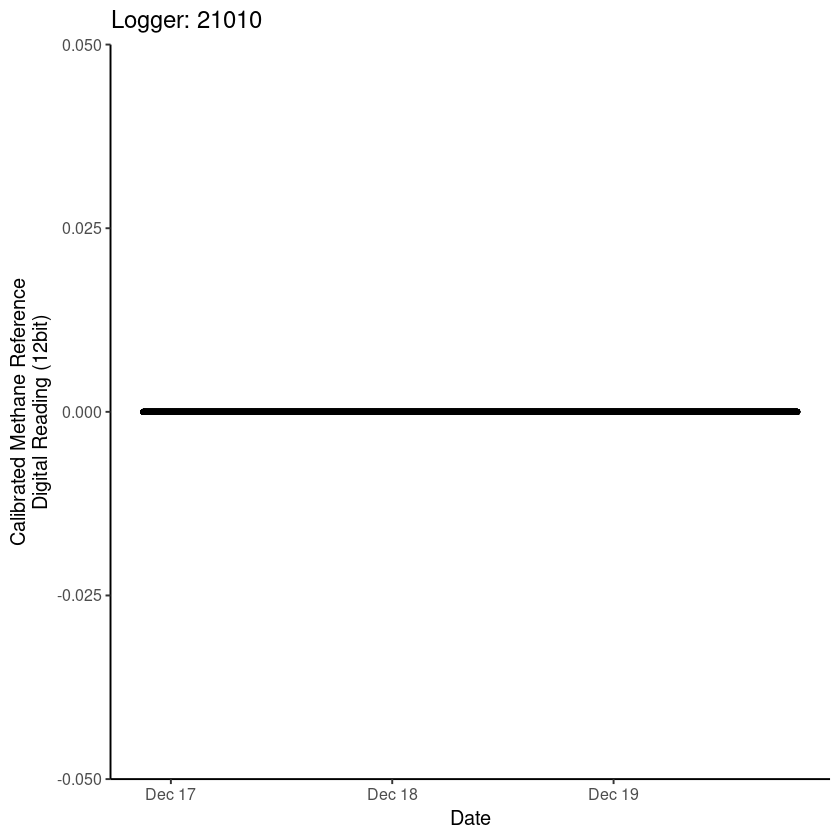

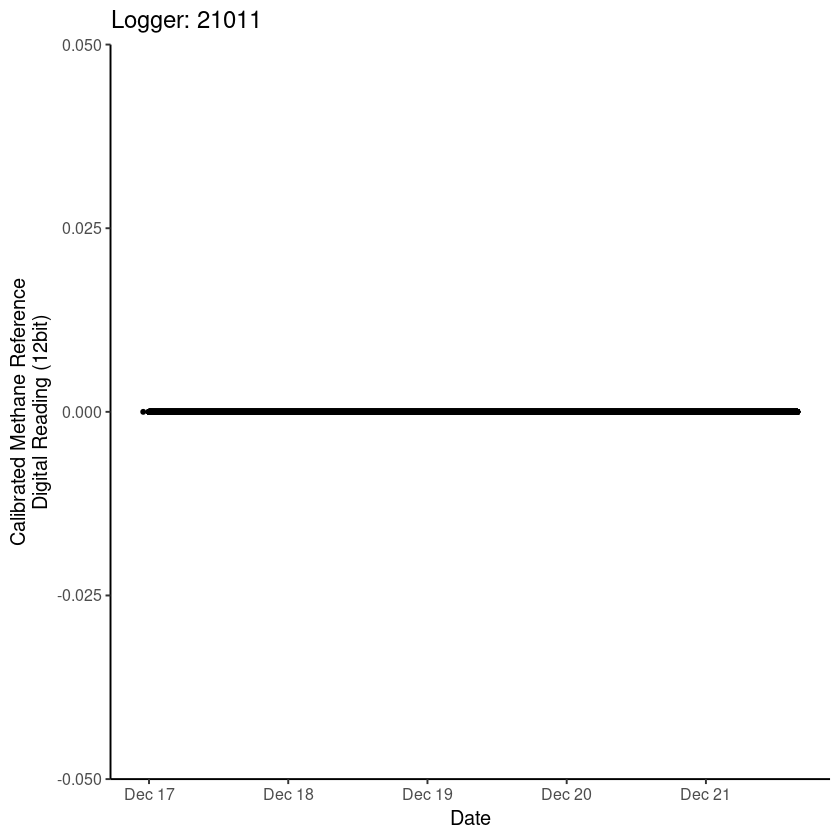

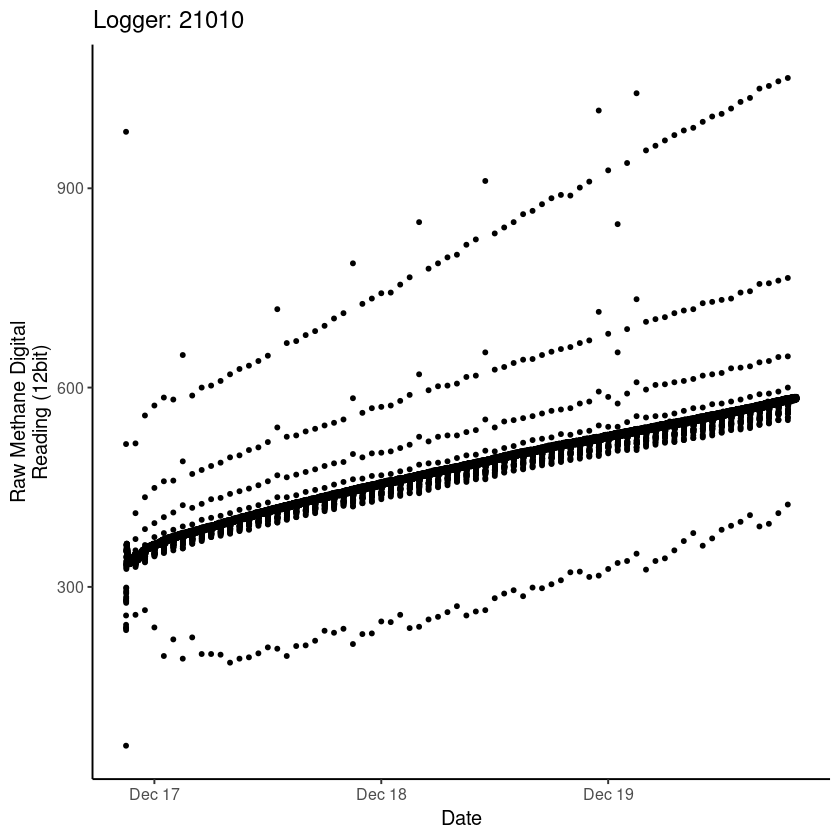

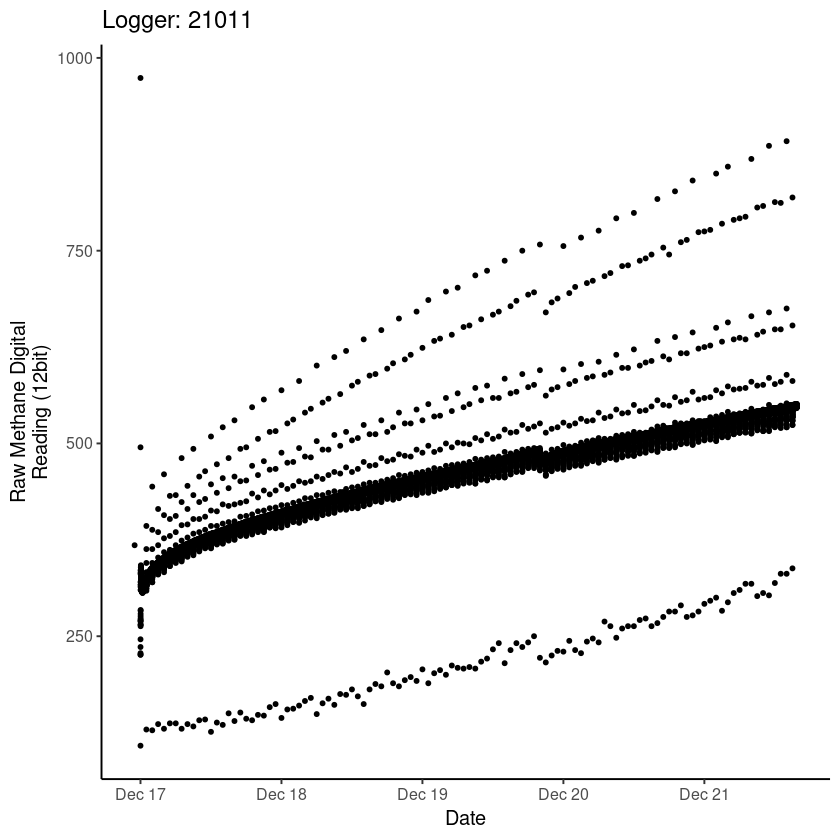

$battery.V
$battery.V$`21010`

$battery.V$`21011`


$dht_C
$dht_C$`21010`

$dht_C$`21011`


$dht_RH
$dht_RH$`21010`

$dht_RH$`21011`


$ch4rf_raw
$ch4rf_raw$`21010`

$ch4rf_raw$`21011`


$ch4rf_cal
$ch4rf_cal$`21010`

$ch4rf_cal$`21011`


$ch4_raw
$ch4_raw$`21010`

$ch4_raw$`21011`


$ch4_cal
$ch4_cal$`21010`

$ch4_cal$`21011`



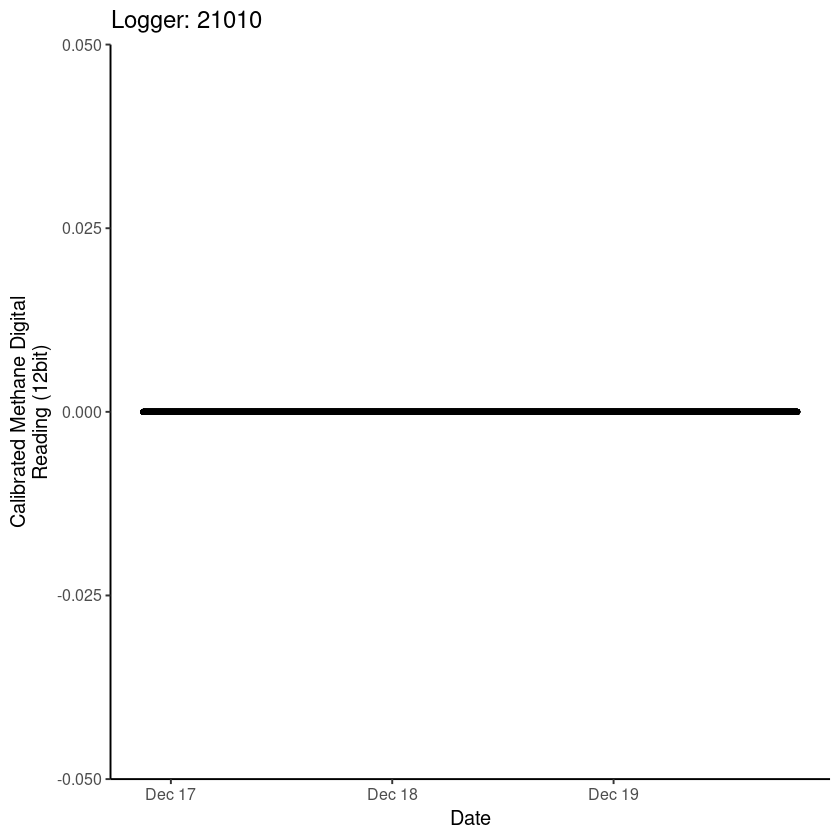

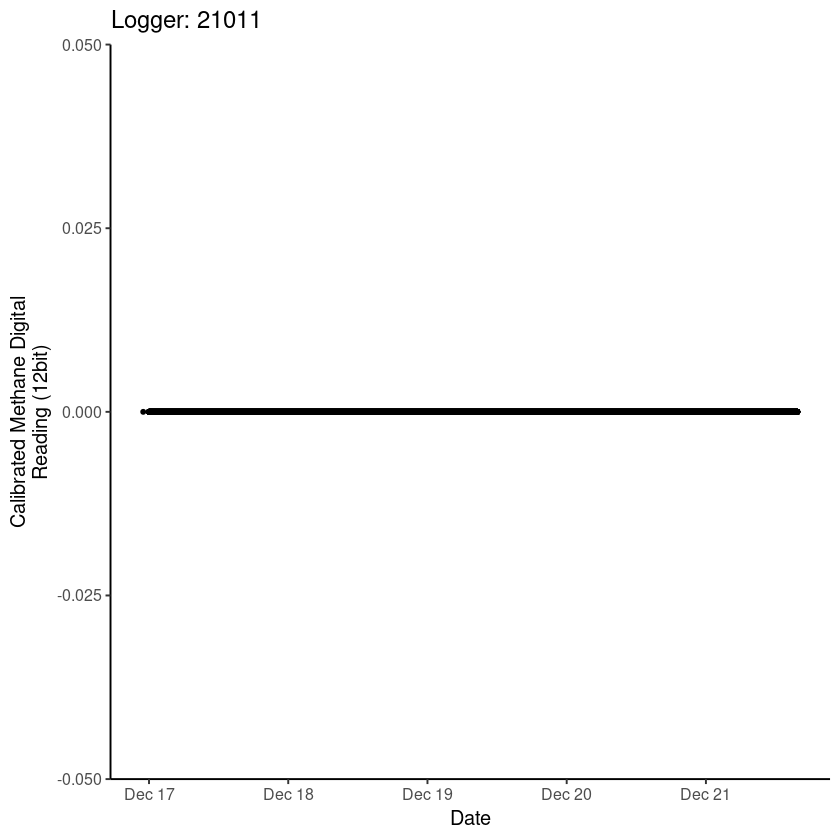

In [39]:
rawPD_individualPlots<-plot_individual_logger_data_v_time(raw_processed_data)

rawPD_individualPlots

savePlotListList(rawPD_individualPlots, "ip_all_raw_")

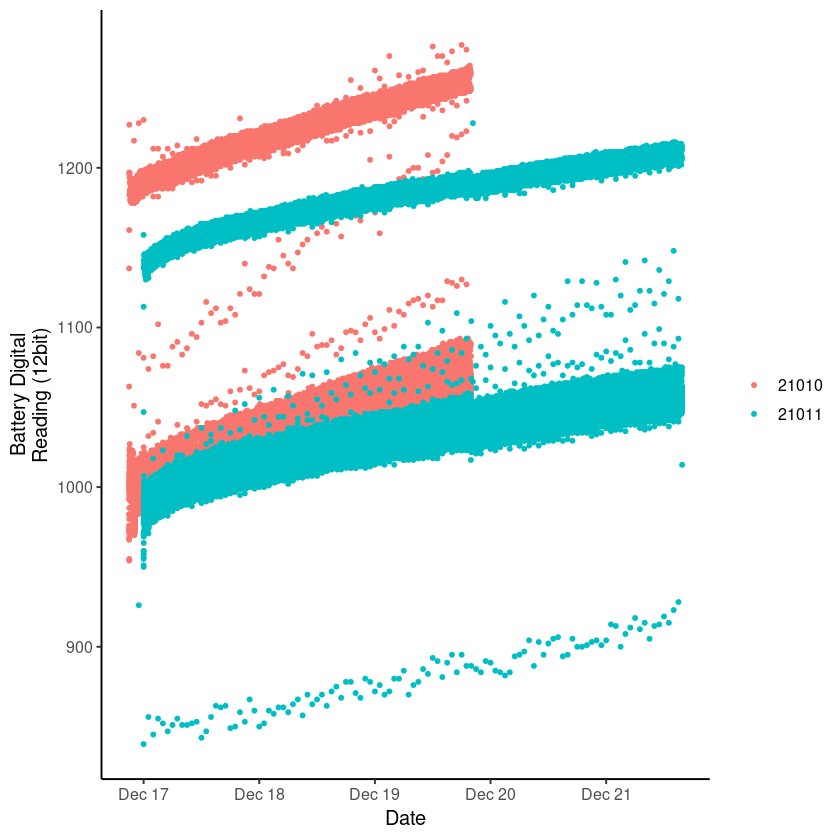

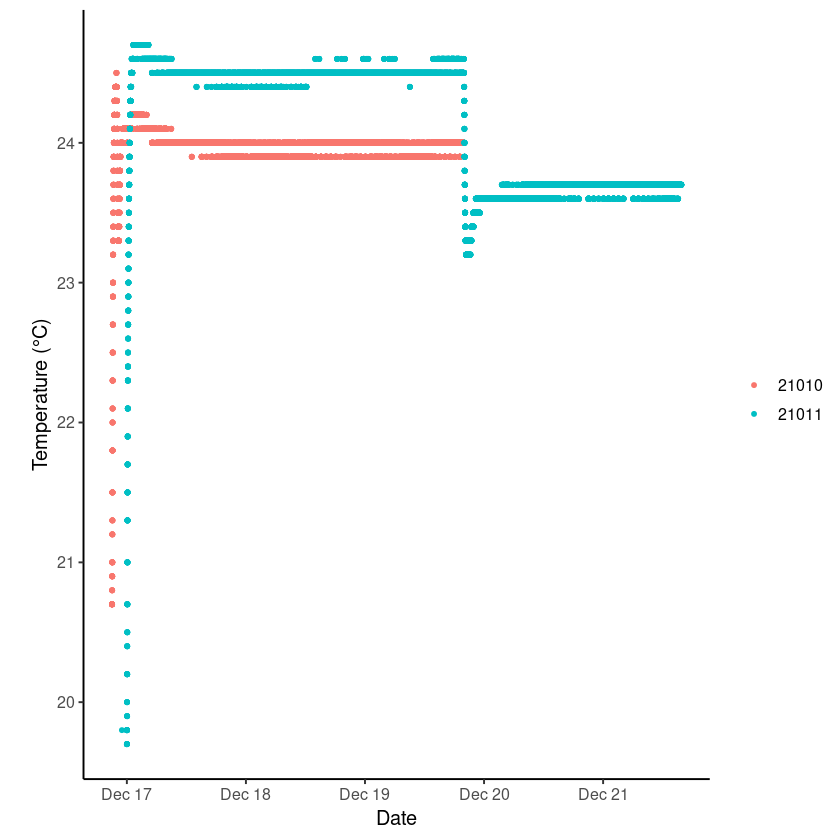

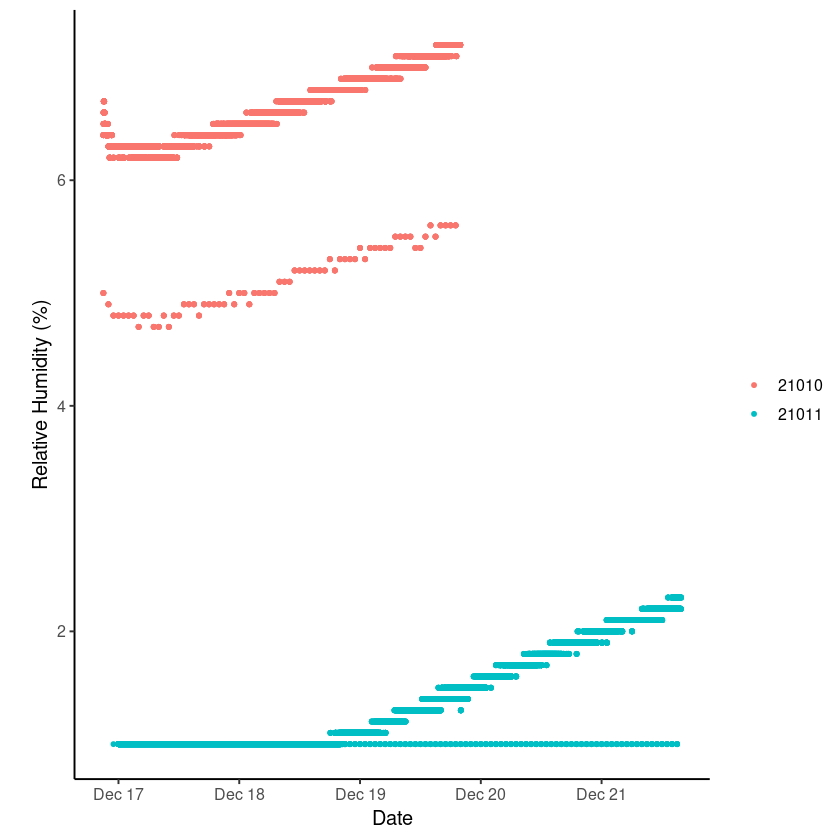

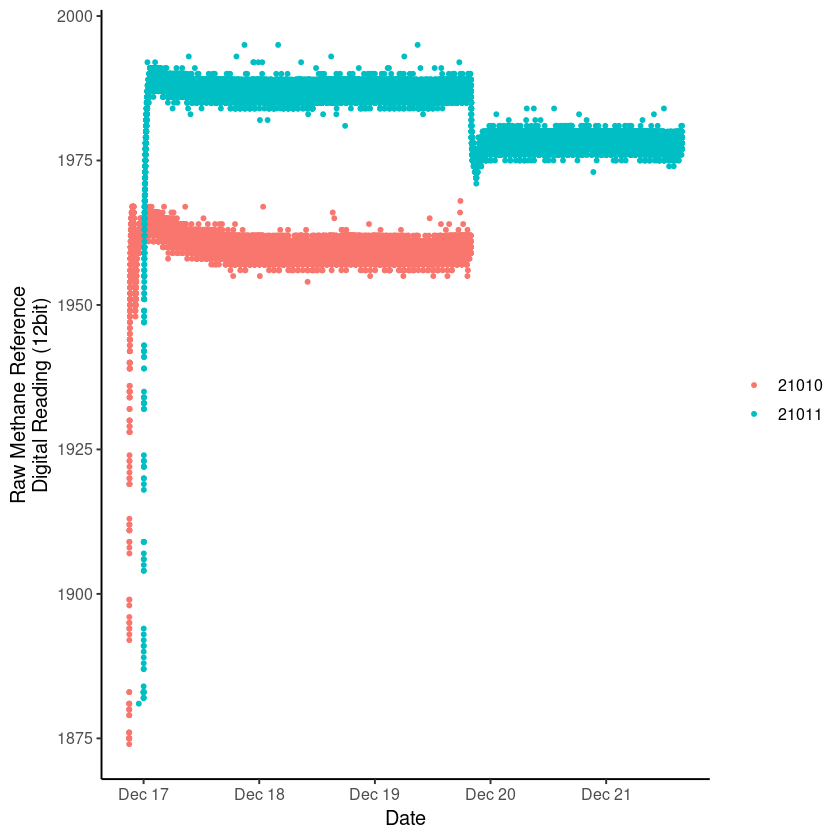

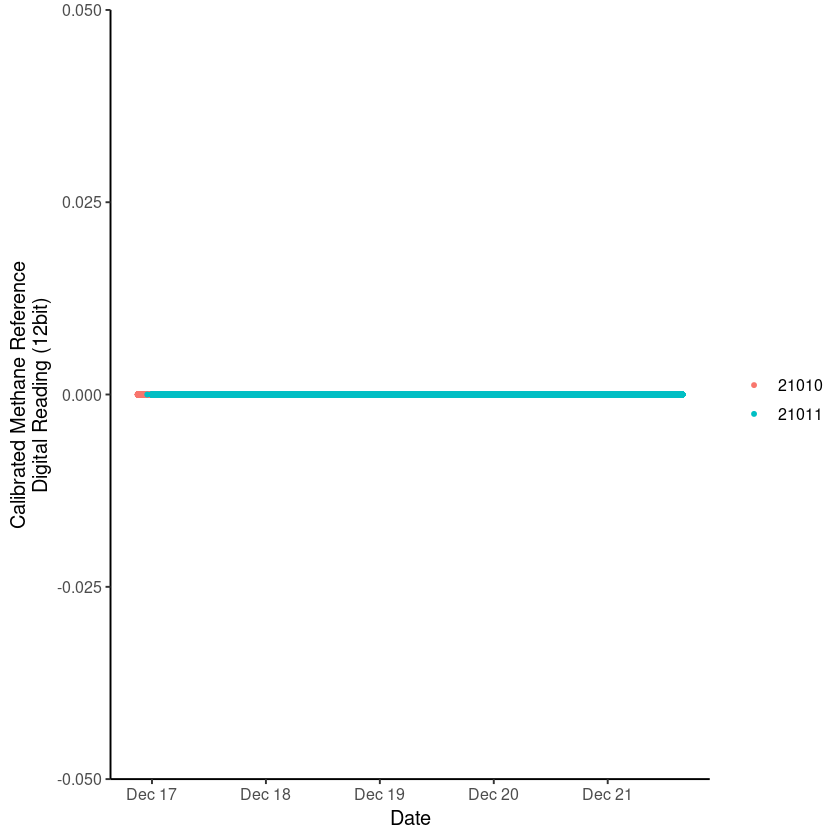

$battery.V

$dht_C

$dht_RH

$ch4rf_raw

$ch4rf_cal

$ch4_raw

$ch4_cal


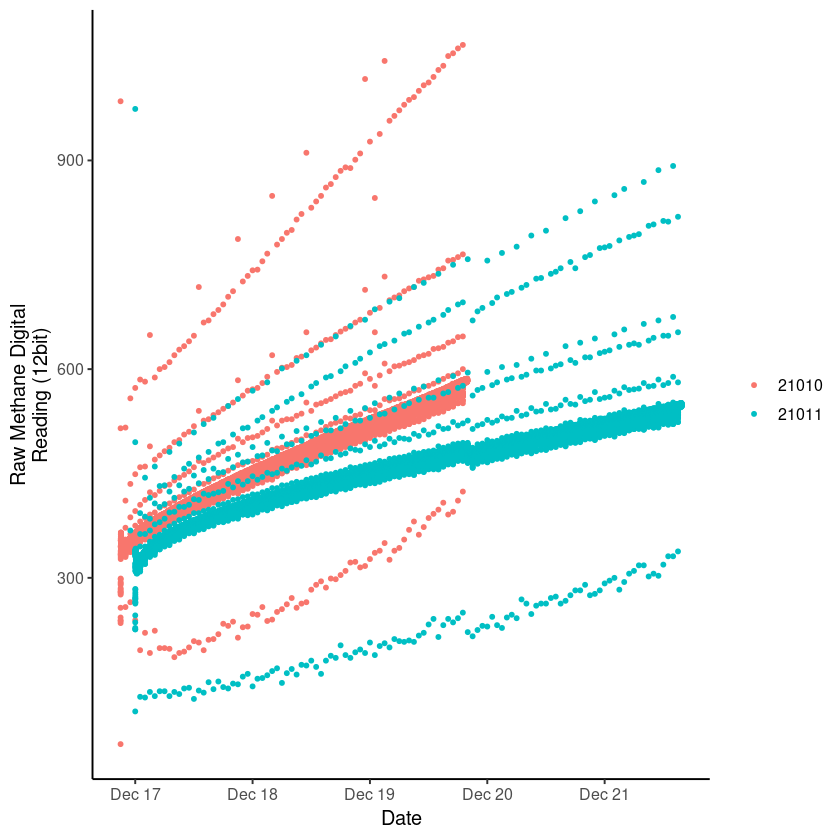

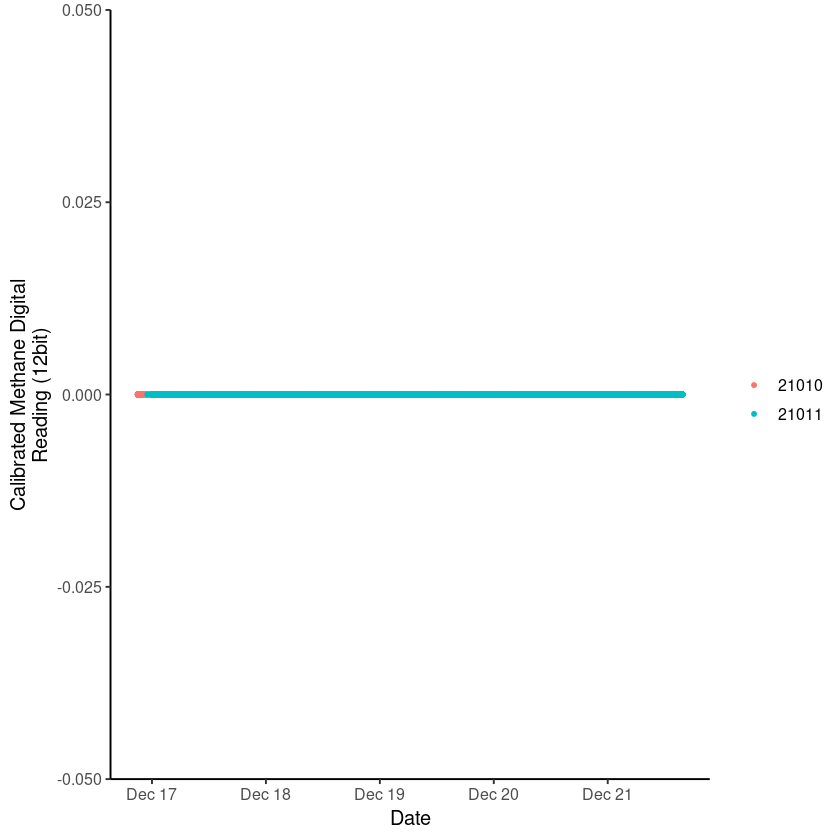

In [40]:
rawPD_loggerPlots<-plot_Data_v_Time(raw_processed_data, "logger")
rawPD_loggerPlots

savePlotList(rawPD_loggerPlots, "lp_all_raw_")

In [41]:
# head(raw_processed_data)

In [42]:
# lookat<-subset(summary_manualCVdata, logger=loggerList[1])
# head(lookat)

# names(individualPlots[[1]])

# deparse(substitute(individualPlots))
# deparse(quote(individualPlots))

# class(summary_manualCVdata$logger)

#### Burst vs CH4, colored by measurementCycle
#TODO all variables?

In [43]:
# summary_CvVsCH4_plots<-cycleVsCH4_plots(summary_manualCVdata, "summary")

# summary_CvVsCH4_plots

# savePlotList(summary_CvVsCH4_plots, "summary_CvVsCH4_")

In [44]:
# test<-subset(summary_manualCVdata,logger==21003 & type=="summary")
# test
# length(test[,1])

#### Time vs CH4

In [45]:
# timeVsCH4_plots<-function(df, loggerCount, loggerList, dataType){
#     plots<-vector("list", loggerCount)
#     names(plots)<-loggerList
#     for(i in 1:loggerCount){
#         data<-subset(df,logger==loggerList[i] & type==dataType)
#         plots[[i]]<-ggplot(data,aes(time.h,ch4_raw))+
#         geom_point()+ggtitle(paste("Logger: ",loggerList[i],"\nData type: ", dataType,sep=""))
#     }
#     return(plots)
# }

In [46]:
# manualCV_timeVsCH4_plots<-timeVsCH4_plots(summary_manualCVdata, loggerCount, loggerList, "summary")

# manualCV_timeVsCH4_plots

# savePlotList(manualCV_timeVsCH4_plots, outputDir, "manualCV_timeVsCH4_")

#### Time vs Temperature (C)

In [47]:
# timeVsC_plots<-function(df, loggerCount, loggerList, dataType){
#     plots<-vector("list", loggerCount)
#     names(plots)<-loggerList
#     for(i in 1:loggerCount){
#         data<-subset(df,logger==loggerList[i] & type==dataType)
#         plots[[i]]<-ggplot(data,aes(time.h,dht_C))+
#         geom_point()+ggtitle(paste("Logger: ",loggerList[i],"\nData type: ", dataType))
#     }
#     return(plots)
# }

In [48]:
# manualCV_timeVsC_plots<-timeVsC_plots(summary_manualCVdata, loggerCount, loggerList, "summary")

# manualCV_timeVsC_plots

# savePlotList(manualCV_timeVsC_plots, outputDir, "manualCV_timeVsC_")

#### Time vs Relative Humidity plots

In [49]:
# timeVsRH_plots<-function(df, loggerCount, loggerList, dataType){
#     plots<-vector("list", loggerCount)
#     names(plots)<-loggerList
#     for(i in 1:loggerCount){
#         data<-subset(df,logger==loggerList[i] & type==dataType)
#         plots[[i]]<-ggplot(data,aes(time.h,dht_RH))+
#         geom_point()+ggtitle(paste("Logger: ",loggerList[i],"\nData type: ", dataType))
#     }
#     return(plots)
# }

In [50]:
# manualCV_timeVsRH_plots<-timeVsRH_plots(summary_manualCVdata, loggerCount, loggerList, "summary")

# manualCV_timeVsRH_plots

# savePlotList(manualCV_timeVsRH_plots, outputDir, "manualCV_timeVsRH_")


In [51]:
# TODO: place these respective plots next to each other for better visualization? 
# either group by logger, or group by type of data?

In [52]:
# cv_burst_20<-subset(parseDataCV,logger==21004 & as.integer(burst)>20)

# mean_na<-function(x){mean(x,na.rm=TRUE)}

# test<-summaryBy(roll_cv~measurement_cycle,cv_burst_20,FUN=c(mean_na))
# test$logger<-unique(cv_burst_20$logger)
# test$deployed_at<-lubridate::as_datetime(unique(cv_burst_20$deployed_at))

In [53]:
# comp_cv_burst_20<-subset(comp_cv_50FF74068678545256252467,burst>20)

In [54]:
# mean_na<-function(x){mean(x,na.rm=TRUE)}

# comp_sum_50FF74068678545256252467<-summaryBy(roll_cv~measurement_cycle,comp_cv_burst_20,FUN=c(mean_na))
# comp_sum_50FF74068678545256252467$uuid<-unique(comp_cv_50FF74068678545256252467$uuid)
# comp_sum_50FF74068678545256252467$deployed_at<-lubridate::as_datetime(unique(comp_cv_50FF74068678545256252467$deployed_at))

In [55]:
# head(comp_sum_50FF74068678545256252467)
# saveRDS(comp_sum_50FF74068678545256252467,"comp_sum_50FF74068678545256252467.rds")

In [56]:
# comp_parse<-parse_data(subset(comp_data,uuid=="50FF74068678545256252467"),30,30)
# ggplot(comp_parse,aes(as.factor(burst),atlas_CO2_ppm))+
# geom_point()

### Calculating rolling CV on a measurement cycle.

In [57]:
# head(comp_parse)

In [58]:
# comp_data_sum<-summaryBy(ch4_raw+ch4rf_raw~dtp+uuid,comp_parse,FUN=c(sd,mean))

In [59]:
# head(comp_data_sum)
#comp_parse$dtp

## Plotting average values per burst.

In [60]:
# comp_data_sum$dtp<-as_datetime(comp_data_sum$dtp)

# head(comp_data_sum)

# ggplot(comp_data_sum,aes(dtp,ch4_raw.mean))+
# geom_point()+
# facet_wrap(.~uuid)


# ggplot(comp_data_sum,aes(dtp,ch4rf_raw.mean))+
# geom_point()+
# facet_wrap(.~uuid)

# comp_data_sum$ch4_raw_norm<-comp_data_sum$ch4_raw.mean/comp_data_sum$ch4rf_raw.mean

# ggplot(comp_data_sum,aes(dtp,ch4_raw_norm))+
# geom_point()+
# facet_wrap(.~uuid)

In [61]:
# ggplot(subset(comp_data),aes(dtp,battery.V))+
#     geom_point(aes(color=as.factor(group)))+
# ylim(1500,1650)

In [62]:
# names(comp_data)

In [63]:
# ggplot(comp_data,aes(dtp,atlas_CO2_ppm))+
#        geom_point()

In [64]:
# head(comp_data,n=100)

# scratch

In [65]:
# dir<-'~/Desktop/data/mesoBinTests/20221110_pull/'

In [66]:
# list.files(path=directory2, recursive=TRUE)

In [67]:
# files<-list.files(path=directory2, recursive=TRUE, pattern=".CSV$")

# files

In [68]:
# exclude<-list("notes.txt","debug.csv","metadata.rtf")

# files<-list.files(path=dir, recursive=TRUE)

# files[!(files %in% exclude)]

# Process gas analyzer data

## Function to unzip, read, and concatenate gas analyzer files

In [69]:
concat_gas_analyzer<-function(directory){
    readZIP<-function(filepath){
        fileData<-read.csv(unzip(filepath),skip=1, header=TRUE)
    }

    #list all .zip files
    gas_files<-list.files(path=dir, recursive=TRUE, patter="*.zip$", full.names=TRUE)
    
    #subset files larger than 500 bytes (has content or not)
    gas_files<-subset(gas_files, file.info(gas_files)[,1]>300)

    #read each file and output a single dataframe
    data<-do.call(rbind, lapply(gas_files,readZIP))
    
    #process time column [note: OS is not showing the fractional second, but it is preserved]
    # time column is in PST, change to UTC manually
    if(directory=="~/Desktop/data/mesoBinTests/20221216_Experiment/Gas Analyzer"){
        data$datetime<-lubridate::as_datetime(data$Time,format="%m/%d/%Y %H:%M:%OS", tz="PST")
        #hardcoded switch to UTC, not necessary if input isn't different timezone
        data$datetime<-force_tz(data$datetime, tz="UTC")
    } else {
        data$datetime<-lubridate::as_datetime(data$Time)#,format="%m/%d/%Y %H:%M:%OS", tz="UTC")
    }

    return(data)
}

In [70]:
if(directory=="~/Desktop/data/mesoBinTests/20221216_Experiment/RRIV"){
    dir<-"~/Desktop/data/mesoBinTests/20221216_Experiment/Gas Analyzer"
} else if(directory=="~/Desktop/data/mesoBinTests/20230118_floatingbucket/RRIV"){
    dir<-"~/Desktop/data/mesoBinTests/20230118_floatingbucket/Gas Analyzer"
} else if(directory=="~/Desktop/data/mesoBinTests/20230119_floatingbucket/RRIV"){
    #failed to parse data is switch in timestamp format on gas analyzer from PST to UTC output
    dir<-"~/Desktop/data/mesoBinTests/20230119_floatingbucket/Gas Analyzer"
}
df_gas_analyzer<-concat_gas_analyzer(dir)

In [71]:
# df_gas_analyzer$Time[1]
# df_gas_analyzer$datetime[1]

In [72]:
# head(df_gas_analyzer)
# str(df_gas_analyzer)
# df_gas_cols<-names(df_gas_analyzer)

## Count and remove lines with NA values

In [73]:
sum(is.na(df_gas_analyzer$datetime))

noNA_df_gas_analyzer<-df_gas_analyzer[!is.na(df_gas_analyzer$datetime),]


[1] 0

## Check for data range overlap, if none will not work

In [74]:
range(noNA_df_gas_analyzer$datetime)
range(summary_processed_data$time.h)

[1] "2022-12-19 03:21:55 UTC" "2022-12-20 23:50:02 UTC"

[1] "2022-12-16 21:00:27 UTC" "2022-12-21 15:44:28 UTC"

## initial graphs of data separately

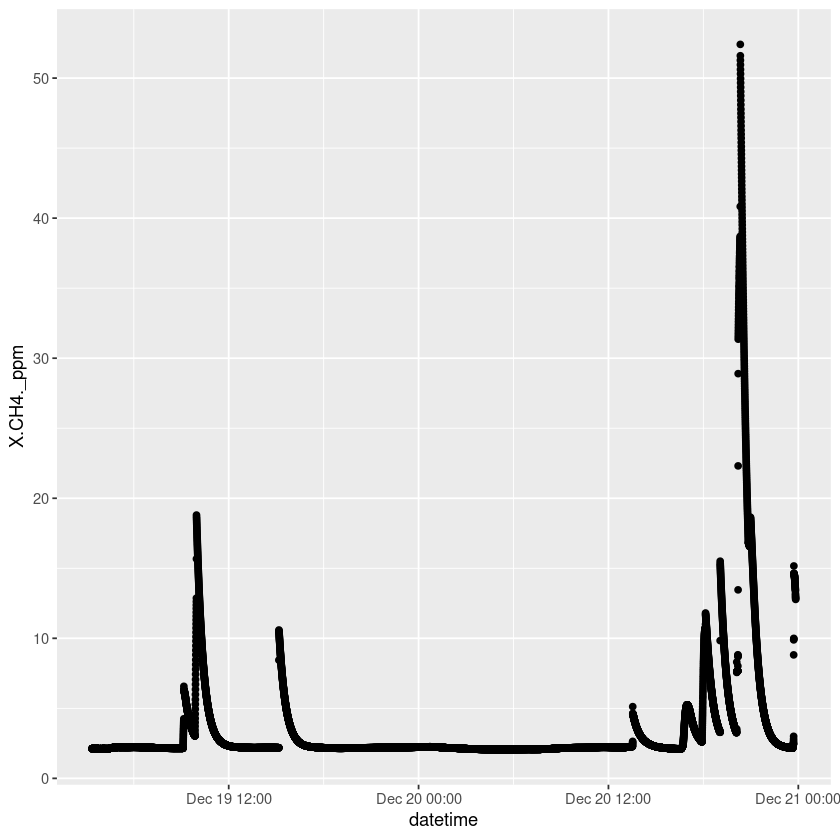

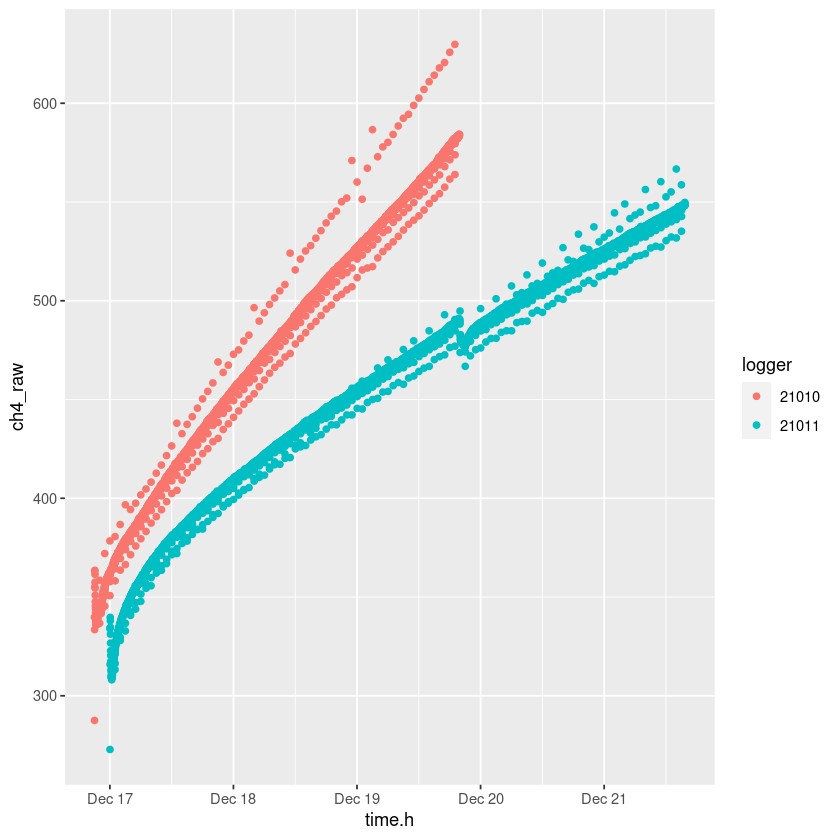

In [75]:
ggplot()+geom_point(data=df_gas_analyzer,aes(x=datetime, y=X.CH4._ppm))
ggplot()+geom_point(data=summary_processed_data, aes(x=time.h, y=ch4_raw, color=logger))

## Overlap data and cut out RRIV warmup section

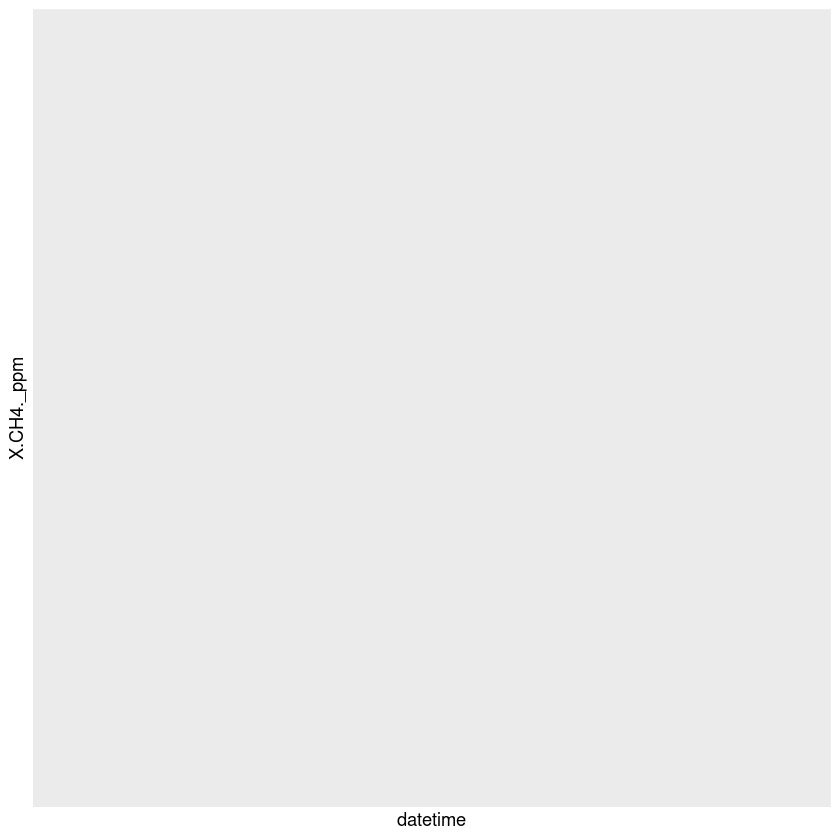

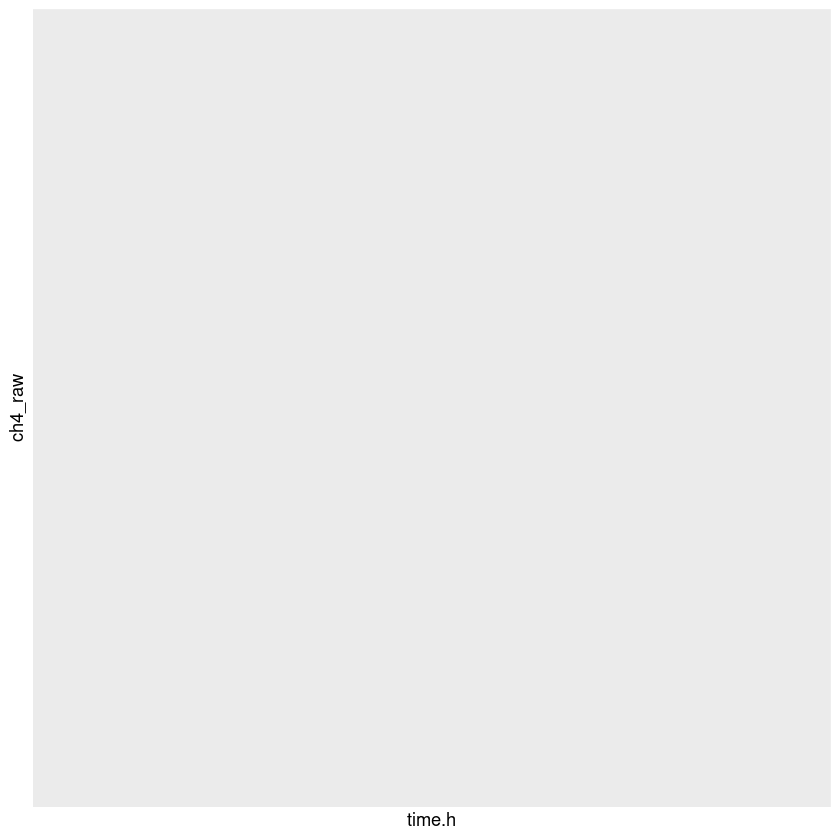

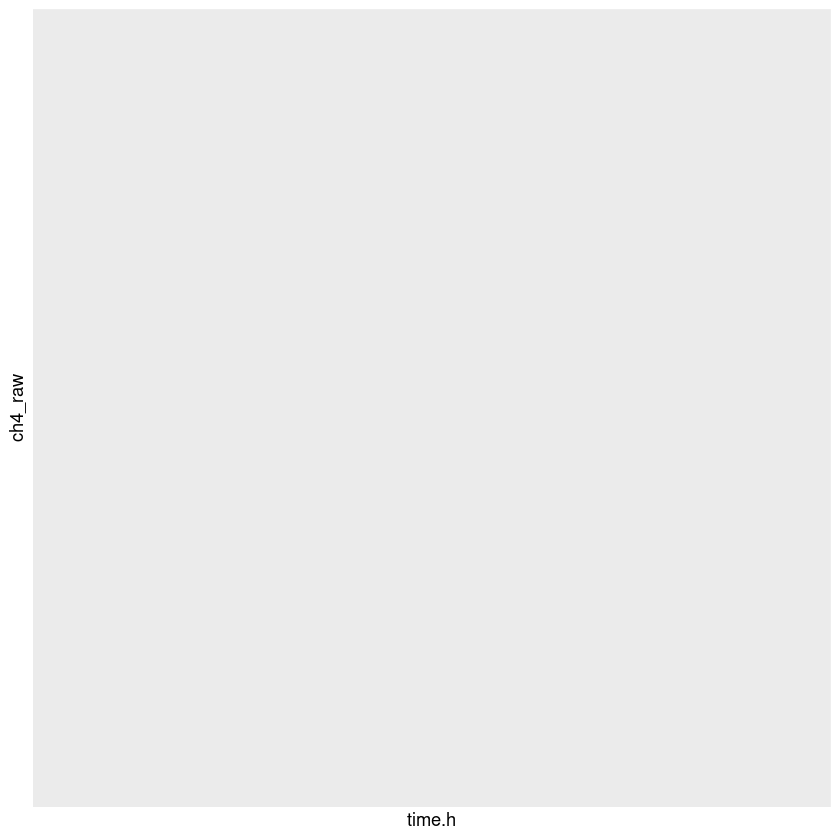

In [76]:
startTime <- "2023-01-19 00:00:00 UTC"
overlap_df_gas_analyzer<-df_gas_analyzer[df_gas_analyzer$datetime > startTime,]
overlap_summary_processed_data<-summary_processed_data[summary_processed_data$time.h > startTime,]

ggplot()+geom_point(data=overlap_df_gas_analyzer,aes(x=datetime, y=X.CH4._ppm))
ggplot()+geom_point(data=overlap_summary_processed_data[overlap_summary_processed_data$logger=="21001",], 
                    aes(x=time.h, y=ch4_raw))
ggplot()+geom_point(data=overlap_summary_processed_data[overlap_summary_processed_data$logger=="21011",], 
                    aes(x=time.h, y=ch4_raw))

# Potential issues?
1. methane data shows noise whenever system sleeps, even if just a minute
2. methane data between RRIV and gas analyzer don't show matching trends
    1. could be due to lack of PTFE surface area for gas exchange
    2. could be due to thickness of PTFE
    3. could be due to trapped gases from Epoxy/PlastiDip curing
    4. could be due to bucket not being air tight at cable glands? seal with molykote or some sort of putty
    
## Test
1. calibrate sensors not in sensor case
2. devise different PTFE method, long tube method?
3. try different material, is silicone more gas permeable?

Warning message in min.default(structure(numeric(0), class = c("POSIXct", "POSIXt":
“no non-missing arguments to min; returning Inf”
Warning message in max.default(structure(numeric(0), class = c("POSIXct", "POSIXt":
“no non-missing arguments to max; returning -Inf”


[1] NA NA

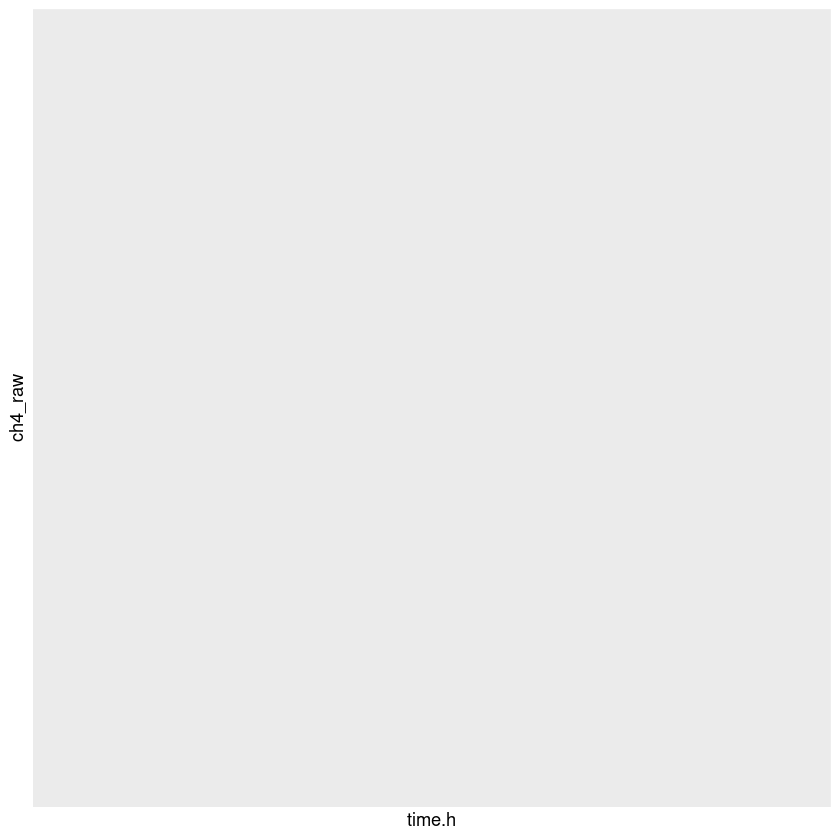

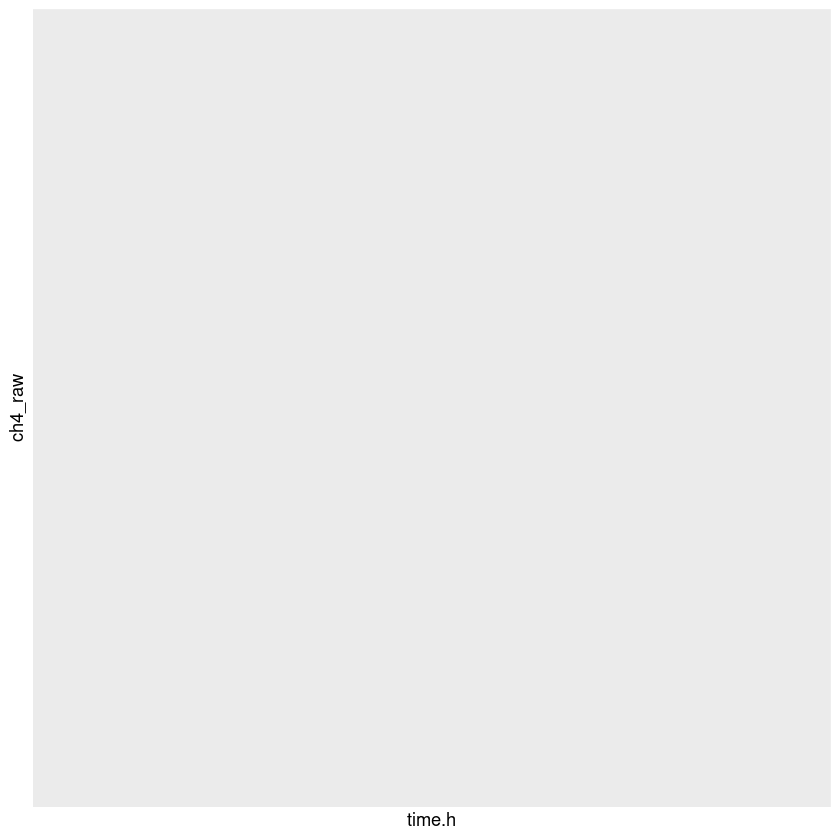

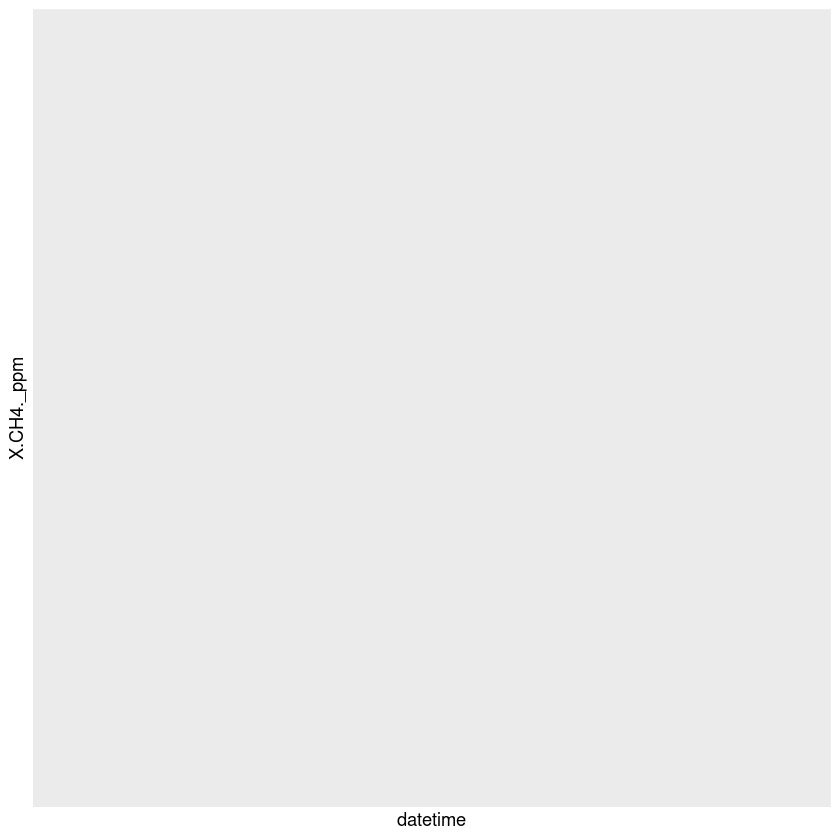

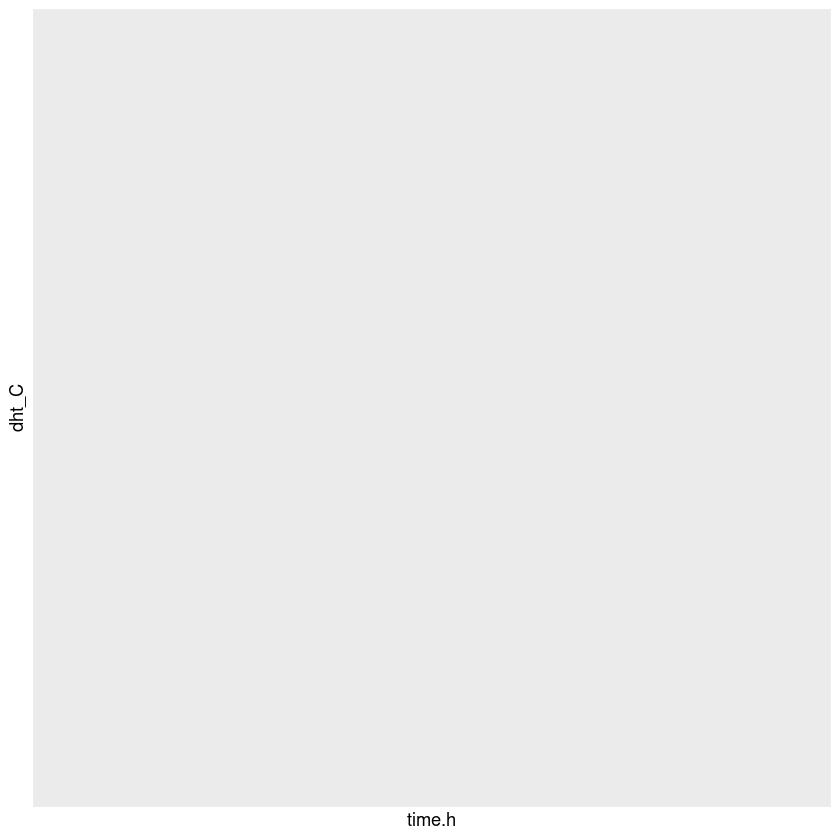

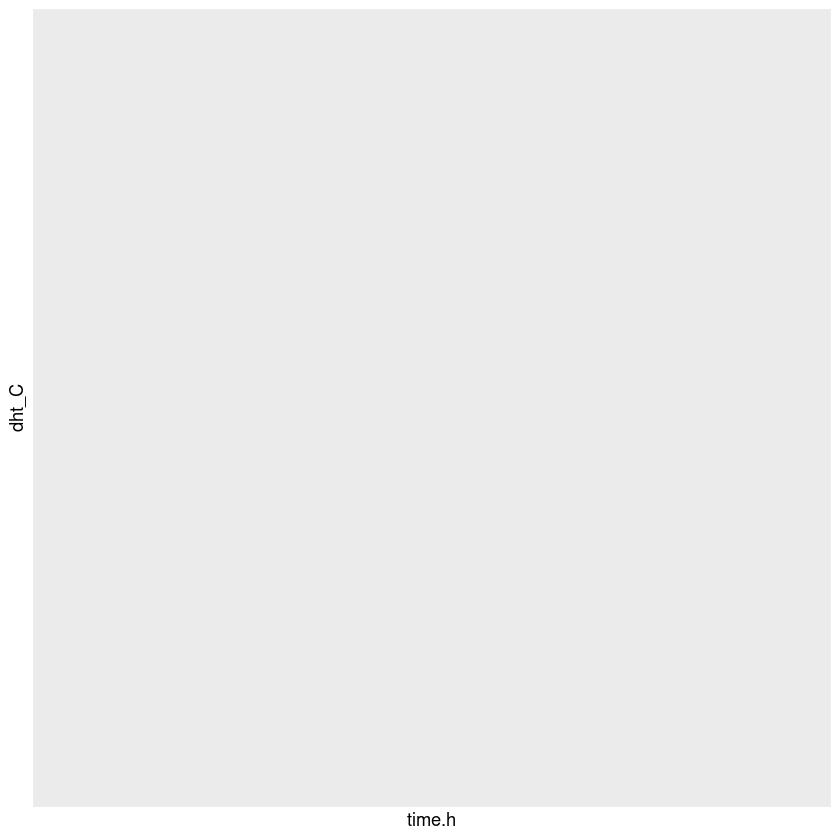

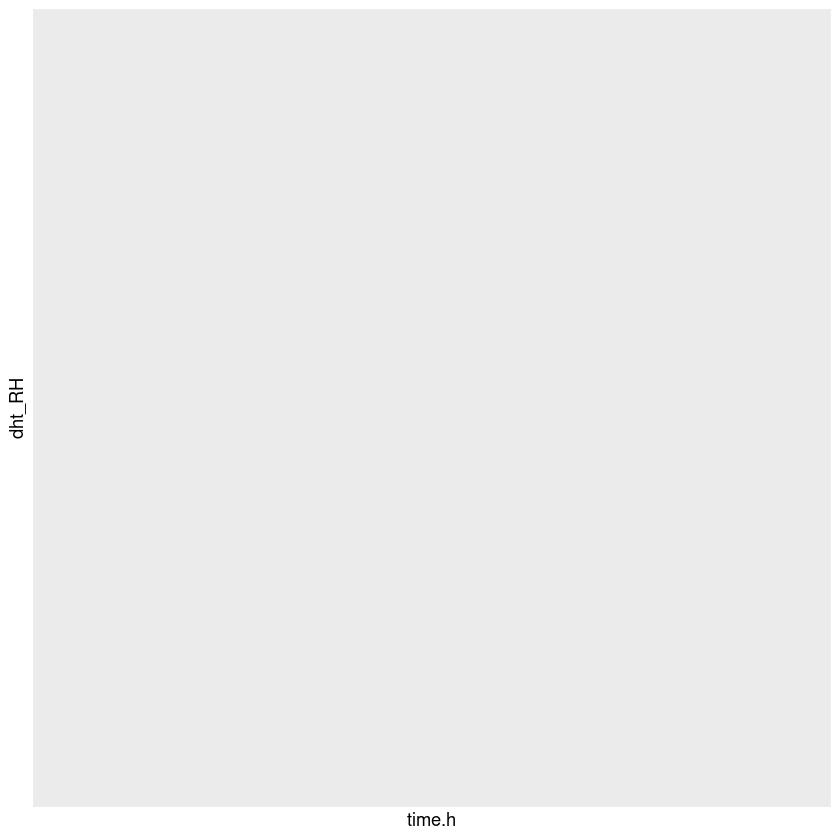

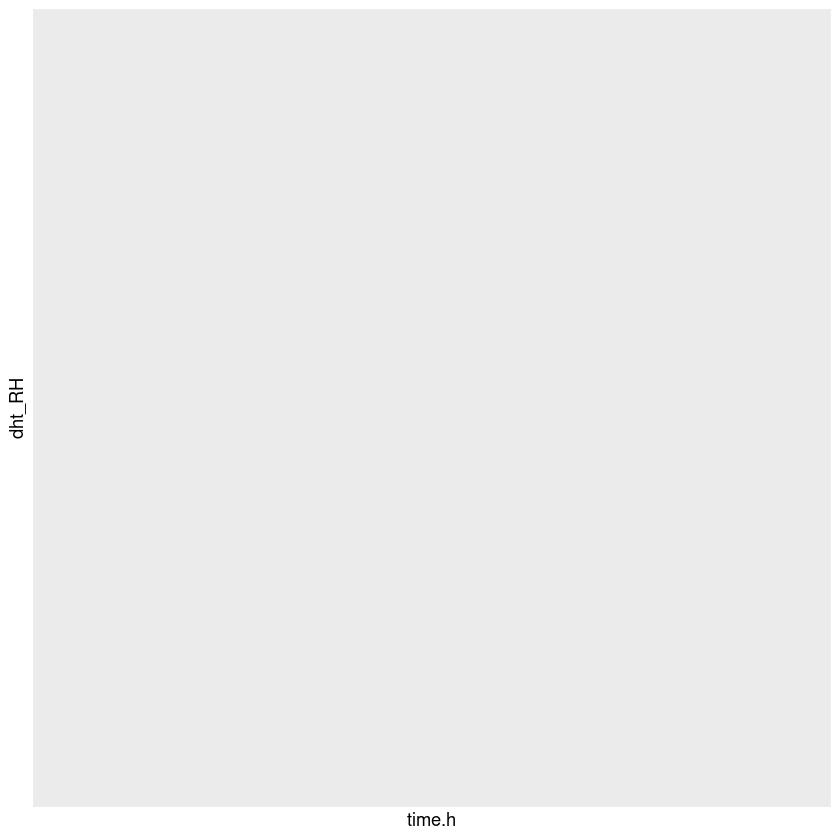

In [77]:
# head(overlap_summary_processed_data)
range(overlap_summary_processed_data$time.h)

startTime<-"2023-01-19 08:10:00 UTC"
endTime<-"2023-01-19 09:00:00 UTC"
subset_ol_sum_pd<-overlap_summary_processed_data[overlap_summary_processed_data$time.h > startTime &
                                       overlap_summary_processed_data$time.h < endTime,]
subset_ol_df_ga<-overlap_df_gas_analyzer[overlap_df_gas_analyzer$datetime > startTime &
                                        overlap_df_gas_analyzer$datetime < endTime,]

ggplot(data=subset_ol_sum_pd[subset_ol_sum_pd$logger=="21001",],aes(x=time.h, y=ch4_raw))+geom_point()
ggplot(data=subset_ol_sum_pd[subset_ol_sum_pd$logger=="21011",],aes(x=time.h, y=ch4_raw))+geom_point()
ggplot(data=subset_ol_df_ga,aes(x=datetime, y=X.CH4._ppm))+geom_point()

ggplot(data=subset_ol_sum_pd[subset_ol_sum_pd$logger=="21001",],aes(x=time.h, y=dht_C))+geom_point()
ggplot(data=subset_ol_sum_pd[subset_ol_sum_pd$logger=="21011",],aes(x=time.h, y=dht_C))+geom_point()

ggplot(data=subset_ol_sum_pd[subset_ol_sum_pd$logger=="21001",],aes(x=time.h, y=dht_RH))+geom_point()
ggplot(data=subset_ol_sum_pd[subset_ol_sum_pd$logger=="21011",],aes(x=time.h, y=dht_RH))+geom_point()

# interpolate data

In [78]:
# head(summary_processed_data)
#separate data from each logger, then add gas analyzer data to each merged by time stamps

#interpolate data using approx() function
overlap_summary_processed_data$ch4_ppm<-approx(x=overlap_df_gas_analyzer$datetime, y=overlap_df_gas_analyzer$X.CH4._ppm, xout=overlap_summary_processed_data$time.h)$y

head(overlap_summary_processed_data)

ERROR: Error in approx(x = overlap_df_gas_analyzer$datetime, y = overlap_df_gas_analyzer$X.CH4._ppm, : need at least two non-NA values to interpolate


# math

In [ ]:
df<-overlap_summary_processed_data
df$dht_K<-df$dht_C+273.15

#determine water vapor saturation point (https://www.orslabs.fr/pdf/Humidity%20Equations.pdf)
P<-1013.25 #millibar, standard pressure ~1 atmosphere
df$ews_mbar<-(1.0007+3.46*10^-6*P)*6.1121^(17.502*df$dht_C/(240.9+df$dht_C))
df$ews_kPa<-df$ews_mbar/10

# # function to lookup pressure at temperatures(https://www.nist.gov/system/files/documents/srd/NISTIR5078-Tab1.pdf)
# # digitized version provided by University of Colorado Boulder (https://learncheme.com/student-resources/steam-tables/)
# steamTablePath<-"~/Desktop/data/mesoBinTests/saturated_by_temperature_V1.4.csv"
# steamTable<-read.csv(steamTablePath, skip=6, header=TRUE)
# # TODO: need to round 0 C or below to 0.01 C, interpolate for values in between table values?
# steamTableLookup<-function(temperature_C){
#     return(as.numeric(steamTable[steamTable[1]==temperature_C,][2]*1000)) # 1MPa=1000kPa
# }
# df$PH2O_kPa<-lapply(round(df$dht_C),steamTableLookup)
# df$PH2O_kPa<-as.numeric(df$PH2O_kPa)
# # df[c("dht_C","PH2O_kPa")]

#convert relative humidity to molar PPM (https://www.learnthermo.com/examples/ch02/p-2d-9.php)
# note: assuming 1 atmosphere, 101.325 kPa, and volume of 1
# df$H2O_mol<-df$dht_RH*df$PH2O_kPa/101.325

df$H2O_mol<-df$dht_RH*df$ews_kPa/101.325
df$BDA_mol<-1-df$H2O_mol #mass of dry air

MW_H2O<-18.01528
MW_BDA<-28.97

df$MW_gas<-df$BDA_mol*MW_BDA+df$H2O_mol*MW_H2O


#vaisala absolute humidity equation (https://www.hatchability.com/Vaisala.pdf)
C<-2.16679 #gK/J
# df$aH_gm3<-C*df$PH2O_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)
df$aH_gm3<-C*df$ews_kPa*(df$dht_RH/100)*1000/(273.15+df$dht_C)

df

In [ ]:
#separate data for each logger

# data_21001<-overlap_summary_processed_data[overlap_summary_processed_data$logger=="21001",]
# data_21011<-overlap_summary_processed_data[overlap_summary_processed_data$logger=="21011",]

In [ ]:
# summary_processed_data$ch4_ppm

In [ ]:
# # ggplot(data=summary_processed_data)+geom_point(color='blue',aes(x=time.h, y=ch4_raw))
# # ggplot(data=summary_processed_data)+geom_point(color='red',aes(x=time.h, y=ch4_ppm))

# # df_gas_analyzer$X.CH4._ppm-raw
# ggplot()+geom_point(data=df_gas_analyzer[df_gas_analyzer$datetime > "2023-01-19 00:00:00 UTC",],aes(x=datetime, y=X.CH4._ppm))
# ggplot()+geom_point(data=summary_processed_data[summary_processed_data$time.h > "2023-01-19 00:00:00 UTC",], aes(x=time.h, y=ch4_raw))

In [ ]:
#convert dht_RH from % to ppm
#hardcode 1013 millibar standard pressure ~ 1 atmosphere
#local pressure can be pulled from Purdue's airport weather station


In [ ]:
# df_gas_analyzer$datetime
# range(df_gas_analyzer$datetime, na.rm=TRUE)
# range(summary_processed_data$time.h)

In [ ]:
# df_gas_analyzer$datetime[1]
# as.numeric(df_gas_analyzer$datetime[1])

## match time range of data sets

In [ ]:
# startTime<-min(df_gas_analyzer$datetime)
# endTime<-max(df_gas_analyzer$datetime)

# # subset manual cv data (not going to be relevant)
# subset_manualCVdata<-summary_manualCVdata[summary_manualCVdata$time.h > startTime &
#                                  summary_manualCVdata$time.h < endTime,]

# #subset raw lines of processed data (summary lines would be better)
# subset_raw_processed_data<-raw_processed_data[raw_processed_data$time.h > startTime &
#                                              raw_processed_data$time.h < endTime,]

# #subset summary lines of processed data
# subset_summary_processed_data<-summary_processed_data[summary_processed_data$time.h > startTime &
#                                                      summary_processed_data$time.h < endTime,]

## rudimentary plots, for general trends
note: compare to all summary lines (not raw lines either) rather than CV, since these runs are 1 minute readings, there should only be 1 warm up

In [ ]:
# ggplot()+geom_point(data=df_gas_analyzer, aes(x=datetime,y=X.CH4._ppm))

# ggplot()+geom_point(data=subset_manualCVdata, aes(x=time.h, y=ch4_raw, color=logger))

# ggplot()+geom_point(data=subset_raw_processed_data, aes(x=time.h, y=ch4_raw, color=logger))

#  ggplot()+geom_point(data=subset_summary_processed_data, aes(x=time.h, y=ch4_raw, color=logger))

In [ ]:
# ggplot()+geom_point(data=df_gas_analyzer, aes(x=datetime,y=X.CO2._ppm))

In [ ]:
# ggplot()+geom_point(data=df_gas_analyzer, aes(x=datetime,y=GasP_torr))

In [ ]:
# ggplot()+
#     geom_point(data=subset_summary_processed_data, aes(x=time.h, y=dht_C, color=logger))+
#     geom_point(data=df_gas_analyzer, aes(x=datetime,y=AmbT_C))

# ggplot()+
#     geom_point(data=summary_processed_data, aes(x=time.h, y=dht_C, color=logger))+
#     geom_point(data=df_gas_analyzer, aes(x=datetime,y=AmbT_C))


## TODO: merge gas analyzer with RRIV data based on timestamps, then plot values together

Then need to fit a calibration equation that includes temperature, relative humidity, and reference voltage effects on CH4 to calibrate